In [ ]:
from shelf.routing import RoutingProblem, Vehicle
from shelf.optimization import GeneticAlgorithm, Solver
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandapower as pp 
import pandapower.networks as pn
import copy
import itertools
import pickle
import numba

from pgmpy.models import BayesianNetwork
from pgmpy.factors.continuous import ContinuousFactor
from pgmpy.factors.discrete import TabularCPD
from scipy.stats import multivariate_normal
import numpy as np
import pandas as pd
from numpy import exp

from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
# add the betweenness centraliy values as new node attributes, then plot
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import pandapower as pp
import pandapower.topology as topS
import pandapower.networks as pn
from sklearn.metrics import f1_score
import random
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.inference import CausalInference
from pgmpy.inference import ApproxInference
from pgmpy.factors.discrete import TabularCPD
from pgmpy.factors.discrete import TabularCPD
from dbn_sep_multi_state import DBN_DS_MS
from dbn_sep_v2 import DBN_DS
import matplotlib as mpl
import api_pp as apipp
from lifelines import *
import scipy
from pymoo.operators.sampling.rnd import BinaryRandomSampling

import pymc as pm
import arviz as az

from dowhy import gcm
import networkx as nx, numpy as np, pandas as pd
import osmnx as ox
import seaborn as sns
import pickle
import igraph as ig
from causallearn.search.FCMBased import lingam
from causallearn.search.FCMBased import lingam
import graphviz
import dowhy
from dowhy.plotter import plot_causal_effect


from collections import Counter

import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling#

#discrete
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import Problem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions


# binary 
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.problems.single.knapsack import create_random_knapsack_problem
from pymoo.termination import get_termination

# Auxiliary functions

In [3]:
# Open a file in write mode
def save_pickle(file_object,file_name):
    with open(file_name, 'wb') as file:
        # Serialize and save the object to the file
        pickle.dump(file_object, file)

def load_pickle(file_name):
    with open(file_name, 'rb') as file:
        # Deserialize and load the object from the file
        loaded_object = pickle.load(file)

    return loaded_object


def generate_pickle_info_from_city(city_name):
    [graph,commercial_nodes,residential_nodes,fuel_nodes,evcs_nodes]=generate_city_information(city_name)

    city_info_dict={'graph':graph,
                    'commercial_nodes':commercial_nodes,
                    'residential_nodes':residential_nodes,
                    'fuel_nodes':fuel_nodes,
                    'evcs_nodes':evcs_nodes}

    file_path='pickle_files/city_info_dict_{}.pickle'.format(city_name)
    save_pickle(city_info_dict,file_path)

def retrieve_city_info(city_name):
    file_name='pickle_files/city_info_dict_{}.pickle'.format(city_name)
    city_info_dict=load_pickle(file_name)
    return city_info_dict




def generate_city_information(city):
    G = ox.graph_from_place(city, network_type="drive")
    G = ox.add_edge_speeds(G)
    G = ox.add_edge_travel_times(G)

    commercial_nodes=[]
    tags = {'building': 'commercial'}
    features=ox.features.features_from_place(city,tags=tags)
    #features_proj = ox.project_gdf(features)
    centroid_features=features.centroid
    for idx in centroid_features.index:
        x=features.centroid.loc[idx].x
        y=features.centroid.loc[idx].y
        node=ox.nearest_nodes(G, x, y, return_dist=False)
        commercial_nodes.append(node)


    # second step: getting possible appartment nodes (home nodes)
    residential_nodes=[]
    tags = {'building': 'residential'}
    features=ox.features.features_from_place(city,tags=tags)
    #features_proj = ox.project_gdf(features)
    centroid_features=features.centroid
    for idx in centroid_features.index:
        x=features.centroid.loc[idx].x
        y=features.centroid.loc[idx].y
        node=ox.nearest_nodes(G, x, y, return_dist=False)
        residential_nodes.append(node)

    tags={'amenity':'charging_station'}
    evcs_nodes=[]
    features=ox.features.features_from_place(city,tags=tags)
    #features_proj = ox.project_gdf(features)
    centroid_features=features.centroid
    for idx in centroid_features.index:
        x=features.centroid.loc[idx].x
        y=features.centroid.loc[idx].y
        node=ox.nearest_nodes(G, x, y, return_dist=False)
        evcs_nodes.append(node)

    tags={'amenity':'fuel'}
    fuel_nodes=[]
    features=ox.features.features_from_place(city,tags=tags)
    #features_proj = ox.project_gdf(features)
    centroid_features=features.centroid
    for idx in centroid_features.index:
        x=features.centroid.loc[idx].x
        y=features.centroid.loc[idx].y
        node=ox.nearest_nodes(G, x, y, return_dist=False)
        fuel_nodes.append(node)
        

    return [G,commercial_nodes,residential_nodes,fuel_nodes,evcs_nodes]







# Various parameters (with references)

In [4]:
n_ev=1000

#source: Spatial-Temporal Distribution Forecasting of Electric Vehicle Charging and Discharging Loads Based on Urban V2G Application


#source: Spatial-Temporal Distribution Forecasting of Electric Vehicle Charging and Discharging Loads Based on Urban V2G Application
#starting travel time
mu_stt=6.92
sigma_stt=1.24

#source: Spatial-Temporal Distribution Forecasting of Electric Vehicle Charging and Discharging Loads Based on Urban V2G Application
#parking time follows a Gumbel distribution. w for work and o for other areas
mu_pt_w=7.31
sigma_pt_w=2.74

mu_pt_o=1.14
sigma_pt_o=1.20

# daily mileage is weibull:
a_dm=32.029 #shape
b_dm=1.23451 #scale

# departure time is weibull
a_dt=7.67
b_dt=21.83

# arrival time is generalized extreme value (cant model in pymc so I will use just weibull)
# k_gev=-0.06
#sigma_gev=0.85
#mu_gev=17.3
a_at=0.85
b_at=17.3
 
# power consumption per kilometer (Source: Optimal scheduling of electric vehicle charging operations considering real-time traffic condition and travel distance)
consumption_per_kilometer=0.15 #kw/kilometer

# current battery sizes for EV (ref: Probabilistic estimation of plug-in electric vehicles charging load profile)
consumption_rate=0.23 #kwh/min

#maximum battery capacity for each EV
max_cap_battery=50


# DATA FOR FUEL BASED VEHICLES
max_fuel_capacity=50 #typical fuel capacity, litros
fuel_consumption_rate=9 #in km/litros, estimativa



# Class Implementation

In [5]:
class EvUser:
    def __init__(self,home,work,index,dm_user,v2g=0,parking_behavior=0,
                 charging_behavior=0,private_charge=0,vehicle_type=1,soc=0.8,initial_time=8):
        #ev_user=EvUser(home,work,user,dm[user],c_v2g[user],c_parking_behavior[user],
                       #c_charging_behavior[user],c_private_charge[user],c_vehicle_type[user])
        ### USER BEHAVIOR ASPECTS
        self.v2g=v2g #0: not v2g, 1: centralized v2g, 2: descentralized v2g
        self.private_charge=private_charge # 0: no private charging, 1: home, 2: work, 3: both work and home
        self.charging_behavior=charging_behavior # 0 wait in private charging location; 1 is go to nearest evcs
        self.parking_behavior=parking_behavior #0 is'charge' based (parking_time=charging_time); 1 is 'loc' based (parking time depends on the destination type: 'H, 'W' or 'P')
        self.private_trip=-1 #-1 if it does private before work; 1 if it does after work; 0 if no preference
        self.soc_min=0.2 #minimum soc (if the soc gets lower than that in a trip, user will recharge)
        self.soc_max=0.8 #maximum soc (if the user is trip based, he will leave the evcs as soon as this level is achieved)
        
        self.vehicle_type=vehicle_type #0 for fuel based, 1 for ev
        self.dm_user=dm_user
        self.home=home
        self.work=work
        
        self.trip_chain_df=pd.DataFrame(columns=['origin','destination','initial_time','final_time','trip_soc','destination_type'])
        self.parking_chain_df=pd.DataFrame(columns=['ev_idx','local','arrival_time','departure_time','arrival_soc','departure_soc'])
        self.ev_consumption=0
        self.fuel_consumption=0
        self.initial_soc=soc
        self.initial_time=initial_time
        self.soc=np.random.uniform(low=0.2,high=0.8) #initial SoC
        self.time=initial_time
        self.index=index
        
    

    def generate_trip_locations(self,weekday_user,n_trips_user):

        trip_chain='H' #starting at home
        # generate trip chain for a single user and a single day
        if(weekday_user==1): #weekday
            available_trips=n_trips_user-2
            trips_before_work=np.random.randint(0,available_trips+1)
            trips_after_work=available_trips-trips_before_work
            for i in range(trips_before_work):
                trip_chain+='P'
            trip_chain+='W'
            for i in range(trips_after_work):
                trip_chain+='P'
            trip_chain+='H'
        else: #weekend, the user does not go to work, instead do only private trips
            for i in range(n_trips_user-2):
                trip_chain+='P'
            trip_chain+='H'
        
        return trip_chain
    
    def simulate_parking(self,G,loc_parking_time,charging_node):
        #print('entrou parking')
        initial_time=self.time
        initial_soc=self.soc
        vehicle_type=self.vehicle_type

        if(vehicle_type==0): #fuel based, the user will fill the tank
            final_soc=1
            final_time=initial_time+5/60 #visit will only take 5 minutes
            parking_time=5
        else: # ev
            if(self.parking_behavior==1): # loc based -> parking time depends on the destination type (H, W or P)
                parking_time=loc_parking_time
            else: #charge based -> calculate time to get to maximum SoC
                parking_time=((self.soc_max-initial_soc)*max_cap_battery)/(consumption_rate*60) #parking time in hours
                #print('test parking time ',parking_time)
            final_soc=min(1,initial_soc+(consumption_rate*parking_time)/max_cap_battery*60) #convert hours to minutes and verify the charging
            final_time=initial_time+parking_time

        
        #print('soc charging',final_soc)
        self.soc=final_soc
        self.time=final_time

        #pd.DataFrame(columns=['local','arrival_time','departure_time'])
        self.parking_chain_df.loc[len(self.parking_chain_df)]=[self.index,charging_node,initial_time,final_time,initial_soc,final_soc]
        return parking_time

    def simulate_trip(self,G,origin,destination,destination_type):
        if(self.private_charge in [1,3] and destination_type=='H'): #user is leaving home -> SoC=1
            initial_soc=1
        else:
            initial_soc=self.soc
        initial_time=self.time
        #print(self.time)
        vehicle_type=self.vehicle_type
        path_time=nx.shortest_path_length(G,origin,destination,weight='travel_time')/(60*60)  # to be in hours
        path_length=nx.shortest_path_length(G,origin,destination,weight='length')
        #print(path_length)
        if(vehicle_type==0): #fuel based
            trip_soc=1e-3*path_length/(fuel_consumption_rate*max_fuel_capacity) 
            final_soc=max(initial_soc-trip_soc,0)
            fuel_consumption=(initial_soc-final_soc)*max_fuel_capacity*path_time #since path_time is in hours and battery capacity is in kw, final value will be in kwh
            ev_consumption=0
        else: #ev
            trip_soc=1e-3*path_length*consumption_per_kilometer/max_cap_battery
            final_soc=max(initial_soc-trip_soc,0)
            fuel_consumption=0
            ev_consumption=max(min(initial_soc-final_soc,1),0)*max_cap_battery*path_time #since path_time is in hours and battery capacity is in kw, final value will be in kwh

        final_time=initial_time+path_time
        self.trip_chain_df.loc[len(self.trip_chain_df)]=[origin,destination,initial_time,final_time,trip_soc,destination_type]
        self.ev_consumption+=ev_consumption
        self.fuel_consumption+=fuel_consumption
        self.soc=final_soc
        self.time=final_time

        return [final_soc,final_time,ev_consumption,fuel_consumption]
    
class EvStation:
    def __init__(self,node_location,num_spots=10,time_horizon=24,time_scale=0.25):
        self.node_location=node_location
        self.num_spots=num_spots

        num_time_slices=int(time_horizon/time_scale)
        self.num_time_slices=num_time_slices
        self.time_horizon=time_horizon
        self.time_scale=time_scale


        self.spots=np.zeros((num_time_slices,num_spots)) # spots(i,j) means that ev i is allocated there at time j
        self.available=[1]*num_time_slices # all spots starts available

        for time_idx in range(num_time_slices):
            for spot_idx in range(num_spots):
                self.spots[time_idx][spot_idx]=-1

    def allocate_ev(self,vehicle,initial_time,final_time): #allocate vehicle at given EvStation at time t
        #print('oii')
        #[i for i in range(len(new_city.evcs_list[0].spots[0])) if new_city.evcs_list[0].spots[0][i]==0]
        initial_time_slice=int(np.round(initial_time/self.time_scale))
        final_time_slice=int(np.round(final_time/self.time_scale))

        available_idx=[i for i in range(len(self.spots[initial_time_slice])) if self.spots[initial_time_slice][i]==-1]

        to_allocate_idx=np.random.choice(available_idx)
        
        for t in range(initial_time_slice,final_time_slice):
            self.spots[t][to_allocate_idx]=vehicle.index

        if(len(available_idx)==1): #if there was only one available spot, this evcs is now not available between initial time and final time
            for t in range(initial_time_slice,final_time_slice):
                self.available[t]=0
    

        
class City:
    def __init__(self,city_name='Esslingen',n_ev=1,n_days=7,p_ev=0.5,num_evcs=None,num_fuel_stations=None,
                 p_v2g=None,p_parking_behavior=None,p_charging_behavior=None,p_private_charging=None,ev_list=None,evcs_list=None):
        self.city_info_dict=retrieve_city_info(city_name)
        self.n_ev=n_ev # number of EVs
        self.n_days=n_days
        self.p_ev=p_ev
        self.time_horizon=24
        self.time_slice=0.25

        #custom probabilities for user behavior
        if(p_v2g==None):
            p_v2g=[1/3,1/3,1/3]

        if(p_parking_behavior==None):
            p_parking_behavior=[1/2,1/2]

        if(p_charging_behavior==None):
            p_charging_behavior=[1/2,1/2]

        if(p_private_charging==None):
            p_private_charging=[1/4,1/4,1/4,1/4]

        #initiate all users in the city
        # first the parameters that are set only once per user
        dm=1000*a_dm*np.random.weibull(a=b_dm,size=n_ev) # daily mileage (for the whole day), convertido em metros


        c_v2g=np.random.choice(np.arange(3),p=p_v2g,size=n_ev) # choice of doing v2g. 0=no vg, 1=centralized v2g, 2=descentralized v2g
        #c_v2g=np.random.randint(low=0,high=3,size=n_ev) 

        c_parking_behavior=np.random.choice(np.arange(2),p=p_parking_behavior,size=n_ev)

        c_charging_behavior=np.random.choice(np.arange(2),p=p_charging_behavior,size=n_ev)

        c_private_charge=np.random.choice(np.arange(4),p=p_private_charging,size=n_ev) # choice of private charging. 0=no, 1=work, 2=home, 3=both
        
        c_vehicle_type=np.random.binomial(n=1,p=p_ev,size=n_ev) # 0 is fuel based, 1 is ev
        
        c_weekday=np.random.binomial(n=1,p=5/7,size=n_days) # verify if it is a weekday or not

        self.G=self.city_info_dict['graph']
        self.commercial_nodes=self.city_info_dict['commercial_nodes']
        self.residential_nodes=self.city_info_dict['residential_nodes']
    
        if(num_evcs==None):
            self.evcs_nodes=self.city_info_dict['evcs_nodes']
        else:
            self.evcs_nodes=np.random.choice(self.city_info_dict['evcs_nodes'],num_evcs)

        if(num_fuel_stations==None):
            self.fuel_nodes=self.city_info_dict['fuel_nodes']
        else:
            self.fuel_nodes=np.random.choice(self.city_info_dict['fuel_nodes'],num_fuel_stations)



        if(ev_list==None):
            self.ev_list=[]
            for user in range(n_ev):
                to_break=False
                while(to_break==False):
                    home=np.random.choice(self.residential_nodes)
                    work=np.random.choice(self.commercial_nodes)
                    if((nx.has_path(self.G,home,work)) and (nx.shortest_path_length(self.G,home,work,weight='length')<dm[user]/2)): # you must be able to at least do H->W->H with your daily mileage
                        to_break=True
                ev_user=EvUser(home,work,user,dm[user],c_v2g[user],c_parking_behavior[user],
                            c_charging_behavior[user],c_private_charge[user],c_vehicle_type[user])
                self.ev_list.append(ev_user)
        else:
            self.ev_list=copy.deepcopy(ev_list)


        if(evcs_list==None):
            self.evcs_list=[]
            for evcs_node in self.evcs_nodes:
                evcs=EvStation(evcs_node)
                self.evcs_list.append(evcs)
        else:
            self.evcs_list=copy.deepcopy(evcs_list)
            self.evcs_nodes=[charging_station.node_location for charging_station in evcs_list]


    def find_available_fuel(self,G,origin):
        destination_list=[fuel for fuel in self.fuel_nodes]
        shortest_path_length=1e9
        for destination in destination_list:
            path_length=nx.shortest_path_length(G,origin,destination,weight='travel_time')
            if(path_length<shortest_path_length):
                shortest_node=destination
                shortest_path_length=path_length

        charging_length=nx.shortest_path_length(G,origin,shortest_node,weight='length')

        return [shortest_node,shortest_path_length,charging_length]

    def find_available_evcs(self,G,origin,t):
        time_idx=int((t/self.time_slice))
        destination_list=[evcs.node_location for evcs in self.evcs_list if evcs.available[time_idx]==1]
        #print(destination_list)
        shortest_path_length=1e9
        for destination in destination_list:
            try:
                path_length=nx.shortest_path_length(G,origin,destination,weight='travel_time')
                #print(path_length)
                if(path_length<shortest_path_length):
                    shortest_node=destination
                    shortest_path_length=path_length
            except:
                pass

        charging_length=nx.shortest_path_length(G,origin,shortest_node,weight='length')

        return [shortest_node,shortest_path_length,charging_length]




    def find_evcs_and_allocate_ev(self,vehicle,charging_node,initial_time,final_time):
        print('eae man',charging_node)
        if(charging_node in self.evcs_nodes): # if node is a evcs, allocate to the proper parking slot. otherwise it is private charging 
            for evcs in self.evcs_list:
                if(evcs.node_location==charging_node):
                    chosen_evcs=evcs
                    break
            
            chosen_evcs.allocate_ev(vehicle,initial_time,final_time)


    def generate_trip_chains(self,weekday=1,to_reset=False):
        # generate a trip for each user in the city, for a single day
        # only the spent SoC for each trip will be considered. not the charged SoC (this will be optimized only on the charging schedule)
        city_info_dict=self.city_info_dict
        G=city_info_dict['graph']
        commercial_nodes=city_info_dict['commercial_nodes']
        residential_nodes=city_info_dict['residential_nodes']
        fuel_nodes=city_info_dict['fuel_nodes']
        evcs_nodes=city_info_dict['evcs_nodes']

        if(to_reset==True):
            for evcs_idx in range(len(self.evcs_list)):
                evcs=self.evcs_list[evcs_idx]
                for time_idx in range(evcs.num_time_slices):
                    for spot_idx in range(evcs.num_spots):
                        evcs.spots[time_idx][spot_idx]=-1


        for vehicle_idx in range(len(self.ev_list)):
            vehicle=self.ev_list[vehicle_idx]
            if(to_reset==True):
                vehicle.parking_chain_df=pd.DataFrame(columns=['ev_idx','local','arrival_time','departure_time','arrival_soc','departure_soc'])
            vehicle.time=copy.deepcopy(vehicle.initial_time)
            vehicle.time=np.random.normal(loc=mu_stt,scale=sigma_stt) #starting travel time
            pt_work_user=np.random.gumbel(mu_pt_w,sigma_pt_w) #Parking time for work location
            pt_other_user=np.random.gumbel(mu_pt_o,sigma_pt_o) #Parking time for other locations
            n_trips_user=np.random.randint(low=2,high=5) #number of trips per day between 2 and 4 accorging to nhts2017
            trip_locations='H' #starting at home
            # generate trip chain for a single user and a single day
            if(weekday==1): #dia util
                available_trips=n_trips_user-2
                if(vehicle.private_trip==-1): #private trip mostly before work
                    trips_before_work=available_trips
                    trips_after_work=0
                elif(vehicle.private_trip==1): #private trip mostly after work
                    trips_before_work=0
                    trips_after_work=available_trips
                else: #no preference
                    trips_before_work=np.random.randint(0,available_trips+1)
                    trips_after_work=available_trips-trips_before_work
                for i in range(trips_before_work):
                    trip_locations+='P'
                trip_locations+='W'
                for i in range(trips_after_work):
                    trip_locations+='P'
                trip_locations+='H'
            else:
                for i in range(n_trips_user-2):
                    trip_locations+='P'
                trip_locations+='H'
            
            individual_trip_list=[(trip_locations[i],trip_locations[i+1]) for i in range(len( trip_locations)-1)]

            for (origin_type,destination_type) in individual_trip_list:
                # first we define origin and departure of the trip
                to_break=False
                while(to_break==False):
                    if(origin_type=='H'):
                        origin=vehicle.home
                    elif(origin_type=='W'):
                        origin=vehicle.work
                    else:
                        origin=np.random.choice(G.nodes)

                    if(destination_type=='H'):
                        destination=vehicle.home
                        parking_time=pt_work_user
                    elif(destination_type=='W'):
                        destination=vehicle.work
                        parking_time=pt_other_user
                    else:
                        destination=np.random.choice(G.nodes)
                    if(nx.has_path(G,origin,destination)):
                        to_break=True
                
                
                path_time=nx.shortest_path_length(G,origin,destination,weight='travel_time')/(60*60)  # to be in hours
                path_length=nx.shortest_path_length(G,origin,destination,weight='length')

                #to-do: check feasibility of the trip. otherwise user will have to charge. and this may generate more trips (charging at origin)
                #to-do: charging at origin (private or public depending on the user choice)
                if(vehicle.vehicle_type==0): # fuel
                    kilometers_left=((vehicle.soc-vehicle.soc_min)*max_fuel_capacity)*fuel_consumption_rate #how many kilometers can you travel with current fuel (considering range anxiety)
                else: # ev
                    kilometers_left=((vehicle.soc-vehicle.soc_min)*max_cap_battery)/consumption_per_kilometer #how many kilometers can you travel with current battery (considering range anxiety)
                
                #print('kilometers left',kilometers_left,1e-3*path_length)
                #print('kilometers comparison',kilometers_left,path_length*1e-3)
                if(kilometers_left<=path_length*1e-3): #must either find charging location or wait for charging at current location
                    if(vehicle.vehicle_type==1):
                        required_soc=((1e-3*path_length)*consumption_per_kilometer)/max_cap_battery
                        parking_time=(required_soc*max_cap_battery)/consumption_rate #required parking time in minutes
                    if(vehicle.charging_behavior=='wait'):
                        initial_time=copy.deepcopy(vehicle.time)
                        real_parking_time=vehicle.simulate_parking(G,parking_time,charging_node=origin) #origin will be 'H' or 'W'
                        self.find_evcs_and_allocate_ev(vehicle=vehicle,charging_node=origin,initial_time=initial_time,final_time=initial_time+real_parking_time)
                        
                    else: #otherwise find a new place to travel and charge
                        if(vehicle.vehicle_type==0): #fuel
                            [charging_node,travelling_time,travelling_length]=self.find_available_fuel(G,origin)
                        else: #ev
                            [charging_node,travelling_time,travelling_length]=self.find_available_evcs(G,origin,vehicle.time)
                        #arriving at destination
                        vehicle.simulate_trip(G,origin,charging_node,destination_type='cs')

                        origin=charging_node #new origin for next trip simulation
                        #charging at destination
                        initial_time=copy.deepcopy(vehicle.time)
                        real_parking_time=vehicle.simulate_parking(G,parking_time,charging_node=charging_node)
                        self.find_evcs_and_allocate_ev(vehicle=vehicle,charging_node=origin,initial_time=initial_time,final_time=initial_time+real_parking_time)

                
                #arriving at destination
                vehicle.simulate_trip(G,origin,destination,destination_type=destination_type)

                #charging at destination (private charging, home or work)
                if(destination_type in ['H','W'] and vehicle.private_charge in [1,3]):
                    initial_time=copy.deepcopy(vehicle.time)
                    real_parking_time=vehicle.simulate_parking(G,parking_time,charging_node=destination)
                    self.find_evcs_and_allocate_ev(vehicle=vehicle,charging_node=origin,initial_time=initial_time,final_time=initial_time+real_parking_time)


                #print(single_fuel_consumption)
                
    def generate_full_parking_df(self):
        df_list=[self.ev_list[i].parking_chain_df for i in range(len(self.ev_list))]
        result=pd.concat(df_list)
        result.index=range(len(result))

        self.full_parking_df=result

        time_steps=range(int(np.round(self.time_horizon/self.time_slice)))

        #self.x_ev=np.zeros((len(self.full_parking_df.index),len(self.evcs_list),len(time_steps))) # x(i,j,t)=1 (0) means that the ev i is (is not) at evcs j at time t

        x_ev_list=[]
        


        #soc_a=np.zeros((len(new_city.ev_list),len(new_city.evcs_list),len(time_steps))) # soc_a(i,j,t)=k means that the ev i arrived in evcs j at time t with soc k
        self.soc_a=np.array(self.full_parking_df.arrival_soc)
        
        #soc_d=np.zeros((len(new_city.ev_list),len(new_city.evcs_list),len(time_steps))) # soc_d(i,j,t)=k means that the ev i left from evcs j at time t with soc k
        self.soc_d=np.array(self.full_parking_df.departure_soc)

        private_parking_list=[]

        for parking_idx in range(len(self.full_parking_df)):
            evcs_node=int(self.full_parking_df.at[parking_idx,'local'])
            evcs_node_location_list=[evcs.node_location for evcs in self.evcs_list]

            if(evcs_node in evcs_node_location_list):
                private_parking_list.append(False)
                x_ev_list.append([])
                evcs_parked_idx=evcs_node_location_list.index(evcs_node)
                t_a=self.full_parking_df.at[parking_idx,'arrival_time']
                t_d=self.full_parking_df.at[parking_idx,'departure_time']

                for evcs_idx in range(len(self.evcs_list)):
                    x_ev_list[-1].append([])
                    if(evcs_idx==evcs_parked_idx):
                        for time in time_steps:
                            if((time*self.time_slice > t_a) and (time*self.time_slice < t_d)):
                                x_ev_list[-1][-1].append(1)
                                #self.x_ev[parking_idx][evcs_idx][time]=1
                            else:
                                x_ev_list[-1][-1].append(0)
                    else:
                        for time in time_steps:
                            x_ev_list[-1][-1].append(0)
            else:
                private_parking_list.append(True)
        
    
        self.x_ev=np.array(x_ev_list)
        #print(private_parking_list)
        #print(len(self.full_parking_df))
        self.full_parking_df=self.full_parking_df.assign(private_parking=private_parking_list)




# Creating the NSGA-II problem

In [6]:

# step 1: defining the problem
class MyProblem(ElementwiseProblem):

    def __init__(self,city):
        self.num_time_slices=int(city.time_horizon/city.time_slice)
        self.x_ev=city.x_ev
        self.soc_a=city.soc_a
        self.soc_d=city.soc_d
        charging_rate_kw=6
        discharging_rate_kw=6
        self.time_slice=city.time_slice
        battery_capacity_kwh=60

        self.charging_rate=(charging_rate_kw*self.time_slice)/battery_capacity_kwh #charging rate in terms of SoC
        self.discharging_rate=(discharging_rate_kw*self.time_slice)/battery_capacity_kwh #discharging rate in terms of SoC
        self.soc_min_list=[]
        self.soc_max_list=[]
        self.alpha_sell=0.1
        self.beta_sell=0.3
        self.alpha_buy=self.alpha_sell/0.98 # The energy selling prices were considered as 98% of the energy buying prices 
        #(source: Charging scheduling in a workplace parking lot: Biobjective optimization approaches through predictive analytics of electric vehicle users' charging behavior
        self.beta_buy=self.alpha_buy

        xl=np.zeros(self.x_ev.shape[0]*self.x_ev.shape[2])
        xu=np.zeros(self.x_ev.shape[0]*self.x_ev.shape[2])

        array_idx=0
        for idx in city.full_parking_df[city.full_parking_df.private_parking==False].index:
            ev_idx=int(city.full_parking_df.at[idx,'ev_idx'])
            evcs_idx=city.full_parking_df.at[idx,'evcs_idx']
            vehicle=city.ev_list[int(ev_idx)]
            self.soc_min_list.append(vehicle.soc_min)
            self.soc_max_list.append(vehicle.soc_max)
            v2g_choice=vehicle.v2g
            for time_idx in range(self.x_ev.shape[2]):
                if(self.x_ev[idx][evcs_idx][time_idx]==0): #ev was not allocated in evcs at that time
                    xl[array_idx]=0
                    xu[array_idx]=0                    
                elif(v2g_choice in [1,2]): #does v2g, either centralized or decentralized
                    xl[array_idx]=-1
                    xu[array_idx]=1
                else:
                    xl[array_idx]=0
                    xu[array_idx]=1
                array_idx+=1

        super().__init__(n_var=self.x_ev.shape[0]*self.x_ev.shape[2],
                         n_obj=3,
                         n_ieq_constr=2*self.x_ev.shape[0]*self.x_ev.shape[2], #soc min and max
                         xl=xl,
                         xu=xu, #to-do: consider the v2g restriction here
                         v_type=int)

    def _evaluate(self, x, out, *args, **kwargs):
        f1=0 # objective 1: user satisfaction
        f2=0 # objective 2: ev profit
        f3=0 #objective 3: minimum load variance (peak valley difference)

        g_list=[]

        soc_array=np.zeros((self.x_ev.shape[0],self.x_ev.shape[2]))

        for ev_idx in range(self.x_ev.shape[0]):
            soc=self.soc_a[ev_idx]
            for time_idx in range(self.num_time_slices):
                charging_decision=x[ev_idx*(self.num_time_slices)+time_idx]
                if(charging_decision==1):
                    soc+=self.charging_rate

                    # linear price function (source: Optimal Spatial–Temporal Scheduling for EVs With Stochastic Behaviors and Possible Inauthentic Information)
                    energy_to_buy=self.charging_rate*max_cap_battery*self.time_slice
                    f2-=self.alpha_buy*energy_to_buy+self.beta_buy #price in ($), negative because the user is buying 
                elif(charging_decision==-1):
                    soc-=self.discharging_rate
                    energy_to_sell=self.discharging_rate*max_cap_battery*self.time_slice
                    f2+=self.alpha_sell*energy_to_sell+self.beta_sell #price in ($), positive because the user is selling (profit)
                soc_array[ev_idx][time_idx]=soc
                g_list.append(self.soc_min_list[ev_idx]-soc)
                g_list.append(soc-self.soc_max_list[ev_idx])


            
            
            
            f1+=np.abs(soc-self.soc_d[ev_idx]) 


            f3_aux=0
            sum_soc=sum(sum(soc_array))
            for ev_idx in range(self.x_ev.shape[0]):
                for time_idx in range(self.num_time_slices):
                    f3_aux+=(soc_array[ev_idx][time_idx]-sum_soc/self.num_time_slices)**2 #to-do: verificar que a implementação está certa

            f3+=f3_aux/(self.x_ev.shape[0]*self.x_ev.shape[2])
        #print(f1+f2+f3)
        

        #f2 = (x[0]-1)**2 + x[1]**2




        #g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        #g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8
        out["F"] = [f1,-f2,f3] #dont forget that f2 is profit so it must be maximized
        #print(f1)
        #out["F"] = [f1] #dont forget that f2 is profit so it must be maximized
        out["G"] = g_list


def optimize_charging_scheduling(city,alg='nsga',n_gen=500):
    if(alg=='GA'):
        algorithm = GA(
        pop_size=20,
        sampling=BinaryRandomSampling(),
        crossover=TwoPointCrossover(),
        mutation=BitflipMutation(),
        eliminate_duplicates=True)
    else:
        algorithm = NSGA2(pop_size=200,
                    n_offsprings=10,
                    sampling=IntegerRandomSampling(),
                    crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
                    mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
                    eliminate_duplicates=True,
                    )

    termination = get_termination("n_gen", n_gen)

    problem = MyProblem(city)

    res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=False,
               return_least_infeasible=True)

    return res


# Spatial temporal results


In [7]:
num_days=7 
n_ev=50

p_v2g=[1,0,0] #0: not v2g, 1: centralized v2g, 2: descentralized v2g
p_parking_behavior=[1/2,1/2]#0 is'charge' based (parking_time=charging_time); 1 is 'loc' based (parking time depends on the destination type: 'H, 'W' or 'P')
p_charging_behavior=[0,1]# 0 wait in private charging location; 1 is go to nearest evcs
p_private_charging=[1,0,0,0] # 0: no private charging, 1: home, 2: work, 3: both work and home




original_city=City(n_ev=n_ev,p_ev=1,p_v2g=p_v2g,p_parking_behavior=p_parking_behavior,p_charging_behavior=p_charging_behavior,
            p_private_charging=p_private_charging)


In [8]:
original_ev_list=copy.deepcopy(original_city.ev_list)
original_evcs_list=copy.deepcopy(original_city.evcs_list)

In [9]:
mcs_iter=20
num_days=7
p_ev=1

behavior_list=['behavior_1','behavior_2','behavior_3','behavior_4']



#behavior_list=['behavior_1']

p_v2g_dict={'no_v2g':[1,0,0],
            'v2g':[0,1,0]}

In [33]:



spatial_temporal_df=pd.DataFrame(columns=['v2g_behavior','user_behavior','ev_profit','ev_satisfaction','evcs_occupation','charging_balance','time_slot','evcs_node','mcs_idx'])

for v2g_name in p_v2g_dict.keys():
    p_v2g=p_v2g_dict[v2g_name]
    for behavior in behavior_list:
        if(behavior=='behavior_1'):
            p_parking_behavior=[0,1]
            p_charging_behavior=[0,1]
        if(behavior=='behavior_2'):
            p_parking_behavior=[0,1]
            p_charging_behavior=[1,0]
        if(behavior=='behavior_3'):
            p_parking_behavior=[1,0]
            p_charging_behavior=[0,1]
        if(behavior=='behavior_4'):
            p_parking_behavior=[1,0]
            p_charging_behavior=[1,0]

        

        new_city_partial=City(n_ev=n_ev,p_ev=p_ev,p_v2g=p_v2g,p_parking_behavior=p_parking_behavior,p_charging_behavior=p_charging_behavior,
                p_private_charging=p_private_charging,ev_list=original_ev_list,evcs_list=original_evcs_list)
        

        for mcs_idx in range(mcs_iter):
            print('################',behavior,v2g_name,mcs_idx)
            new_city_partial.generate_trip_chains(to_reset=True) #generate trips for a single day
            len_full_parking=0
            while(len_full_parking<5):
                for day in range(num_days-1):
                    new_city_partial.generate_trip_chains() #generate trips for a single day
                new_city_partial.generate_full_parking_df()
                len_full_parking=len(new_city_partial.full_parking_df[new_city_partial.full_parking_df.private_parking==False])
                #print(len_full_parking)

            optimization_result=optimize_charging_scheduling(new_city_partial)
            ev_satisfaction=min(np.abs(optimization_result.F[:,1]))
            ev_profit=-np.min(optimization_result.F[:,0])

            # calculating charging balance based on nsga-ii result
            evcs_node_location_list=[evcs.node_location for evcs in new_city_partial.evcs_list]
            total_time_slots=int(new_city_partial.time_horizon/new_city_partial.time_slice)
            charging_rate_kw=6*new_city_partial.time_slice
            discharging_rate_kw=6*new_city_partial.time_slice

            evcs_occupation_dict={}
            for evcs_node in evcs_node_location_list:
                evcs_occupation_dict[evcs_node]=[]
                for time_idx in range(total_time_slots):
                    evcs_occupation_dict[evcs_node].append(0)


            evcs_node_location_list=[evcs.node_location for evcs in new_city_partial.evcs_list]
            for ev_idx in new_city_partial.full_parking_df[new_city_partial.full_parking_df.private_parking==False].index:
                evcs_node=int(new_city_partial.full_parking_df.at[ev_idx,'local'])
                for time_idx in range(total_time_slots):
                    charging_scheduling=optimization_result.X[0][ev_idx*total_time_slots+time_idx]
                    if(charging_scheduling==1):
                        evcs_occupation_dict[evcs_node][time_idx]+=charging_rate_kw
                    elif(charging_scheduling==-1):
                        evcs_occupation_dict[evcs_node][time_idx]-=discharging_rate_kw
                        
            mean_charging_balance_over_time=[np.sum([evcs_occupation_dict[evcs_node][time_idx] for evcs_node in evcs_occupation_dict.keys()]) for time_idx in range(total_time_slots)]
            # calculating evcs occupation level (number of evcs over time)
            num_evs_over_time={}
            for evcs in range(new_city_partial.x_ev.shape[1]):
                num_evs_over_time[evcs]=[]
                for time in range(new_city_partial.x_ev.shape[2]):
                    num_evs_over_time[evcs].append(0)
                    for ev in range(new_city_partial.x_ev.shape[0]):
                        num_evs_over_time[evcs][time]+=new_city_partial.x_ev[ev][evcs][time]
                    num_evs_over_time[evcs][time]/=new_city_partial.x_ev.shape[0]  

            mean_num_evs_over_time=[np.mean([num_evs_over_time[evcs][time] for evcs in range(new_city_partial.x_ev.shape[1])]) for time in range(new_city_partial.x_ev.shape[2])]

            for time_idx in range(total_time_slots):
                charging_balance=mean_charging_balance_over_time[time_idx]
                evcs_occupation=mean_num_evs_over_time[time_idx]
                #spatial_temporal_df=pd.DataFrame(columns=['v2g_behavior','user_behavior','ev_profit','ev_satisfaction','evcs_occupation','charging_balance','time_slot','evcs_node','mcs_idx'])
                spatial_temporal_df.loc[len(spatial_temporal_df)]=[v2g_name,behavior,ev_profit,ev_satisfaction,evcs_occupation,charging_balance,time_idx,evcs_node,mcs_idx]

################ behavior_1 no_v2g 0
eae man 258608028
eae man 254785773
eae man 258608028
eae man 125783998
eae man 255020396
eae man 255020396
eae man 254785773
eae man 258608028
eae man 2883684361
eae man 251882547
eae man 251882547
eae man 254785773
eae man 505385381
eae man 251882547
eae man 251882547
eae man 125783998
eae man 258608028
eae man 258608028
eae man 251882547
eae man 258608028
eae man 251882547
eae man 125783998


KeyboardInterrupt: 

In [36]:
import pickle
import os

to_save_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_applied_energy\pickle_files'

#pickle.dump(spatial_temporal_df,open(os.path.join(to_save_folder,'spatial_temporal_df_full.pickle'),'wb'))

#spatial_temporal_df_1=pickle.load(open(os.path.join(to_save_folder,'spatial_temporal_df_full_v2g.pickle'),'rb'))
#spatial_temporal_df_2=pickle.load(open(os.path.join(to_save_folder,'spatial_temporal_df_full.pickle'),'rb'))
spatial_temporal_df=pickle.load(open(os.path.join(to_save_folder,'spatial_temporal_df_full.pickle'),'rb'))

# Spatial temporal version 1 - v2g as hue

# Consider the following behaviors:
* behavior 1: parking is activity based, always go to evcs
* behavior 2: parking is activity based, always do private charging
* behavior 3: parking is charged based, always to go evcs
* behavior 4: parking is charge based, always do private charging

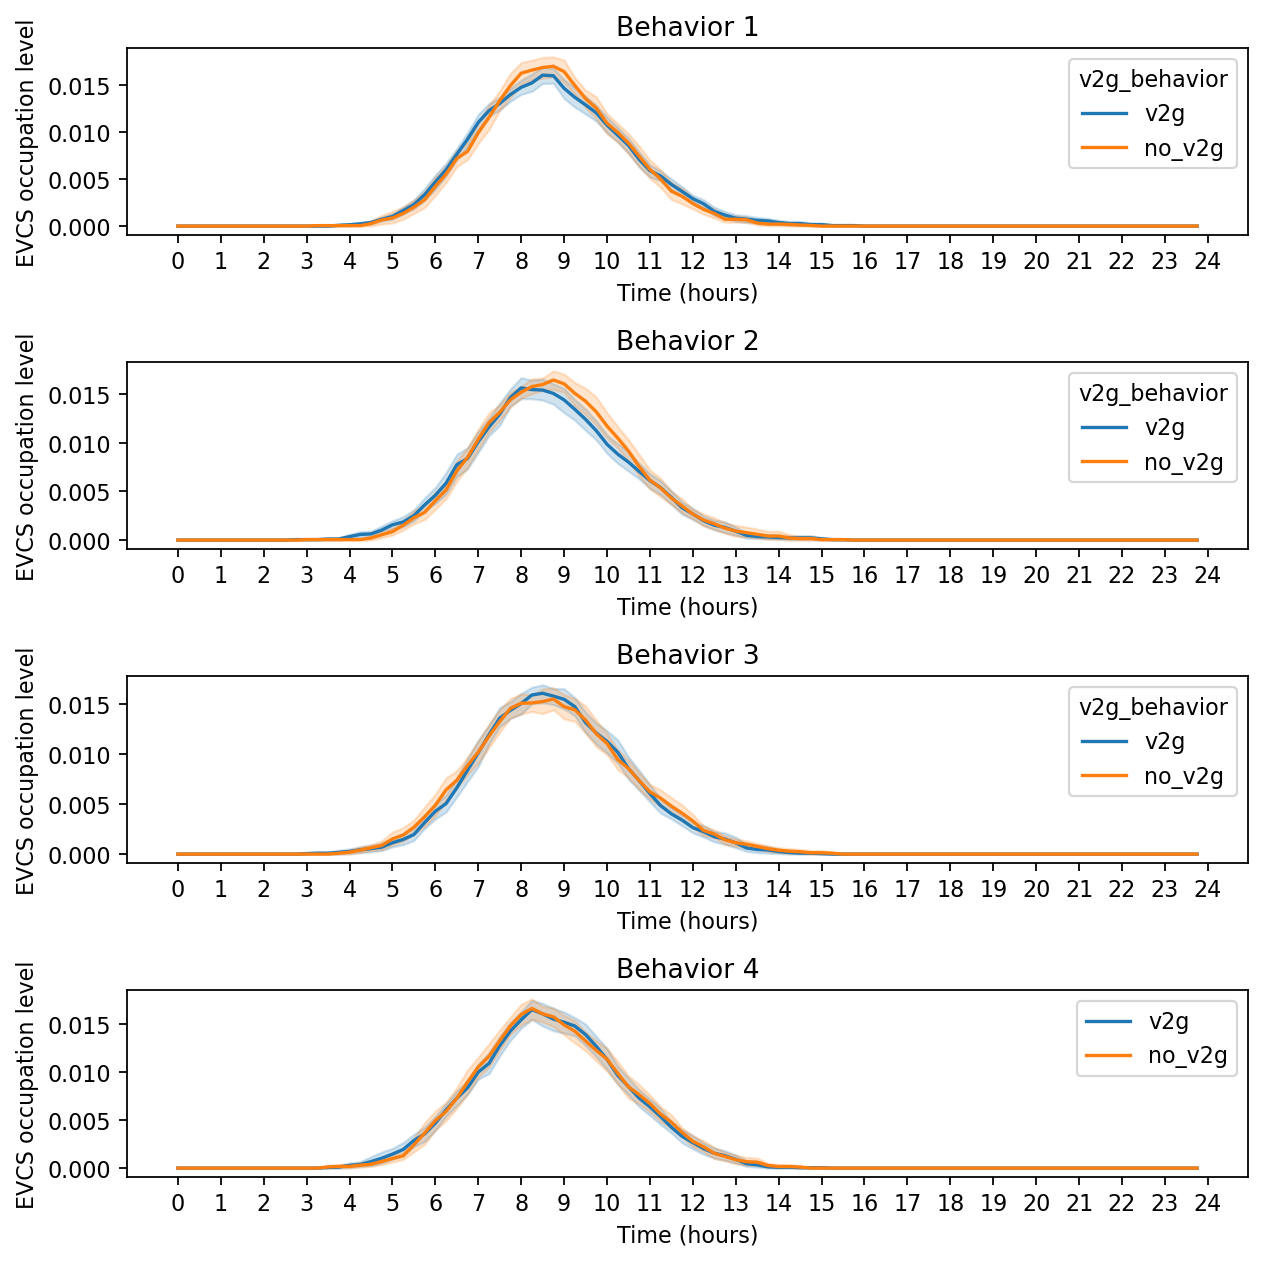

In [58]:
fig,axs=plt.subplots(4,1,figsize=(8,8))
mpl.rcParams['figure.dpi'] = 160
#spatial_temporal_df=pd.DataFrame(columns=['v2g_behavior','user_behavior','ev_profit','ev_satisfaction','evcs_occupation','charging_balance','time_slot','mcs_idx'])

axs[0].set_title('Behavior 1')
axs[0].set_xlabel('Time (hours)')
axs[0].set_ylabel('EVCS occupation level')
axs[0].set_xticks(np.linspace(0,96,25),labels=range(25))
sns.lineplot(data=spatial_temporal_df[spatial_temporal_df.user_behavior=='behavior_1'],x='time_slot',y='evcs_occupation',hue='v2g_behavior',ax=axs[0])

axs[1].set_title('Behavior 2')
axs[1].set_xlabel('Time (hours)')
axs[1].set_ylabel('EVCS occupation level')
axs[1].set_xticks(np.linspace(0,96,25),labels=range(25))
sns.lineplot(data=spatial_temporal_df[spatial_temporal_df.user_behavior=='behavior_2'],x='time_slot',y='evcs_occupation',hue='v2g_behavior',ax=axs[1])

axs[2].set_title('Behavior 3')
axs[2].set_xlabel('Time (hours)')
axs[2].set_xticks(np.linspace(0,96,25),labels=range(25))
axs[2].set_ylabel('EVCS occupation level')
sns.lineplot(data=spatial_temporal_df[spatial_temporal_df.user_behavior=='behavior_3'],x='time_slot',y='evcs_occupation',hue='v2g_behavior',ax=axs[2])

axs[3].set_title('Behavior 4')
axs[3].set_xlabel('Time (hours)')
axs[3].set_ylabel('EVCS occupation level')
axs[3].set_xticks(np.linspace(0,96,25),labels=range(25))
sns.lineplot(data=spatial_temporal_df[spatial_temporal_df.user_behavior=='behavior_4'],x='time_slot',y='evcs_occupation',hue='v2g_behavior',ax=axs[3])


plt.legend(loc='upper right')
plt.tight_layout()
        


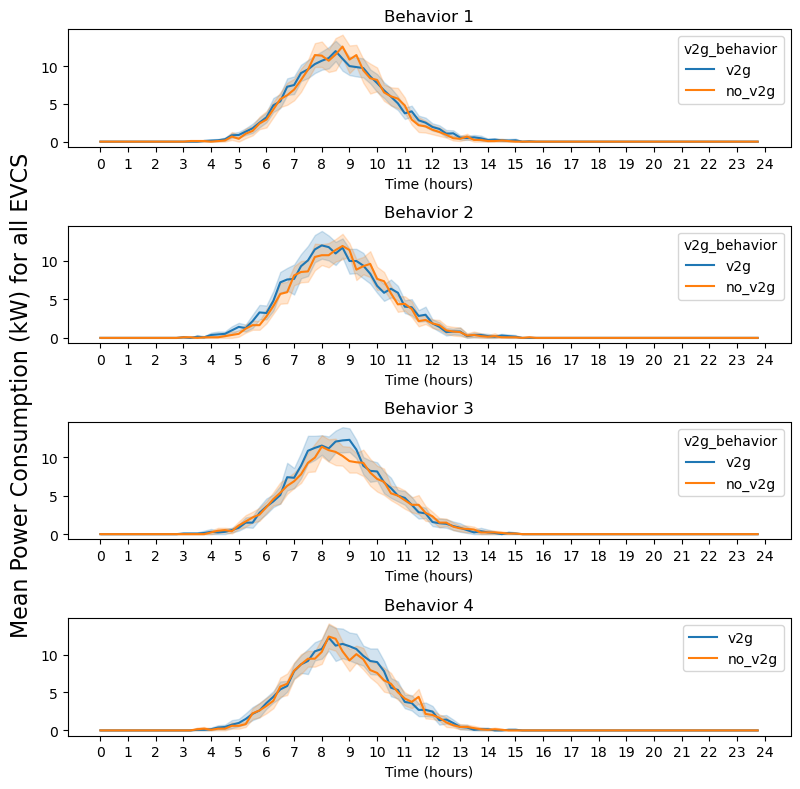

In [13]:
fig,axs=plt.subplots(4,1,figsize=(8,8))
#spatial_temporal_df=pd.DataFrame(columns=['v2g_behavior','user_behavior','ev_profit','ev_satisfaction','evcs_occupation','charging_balance','time_slot','mcs_idx'])

axs[0].set_title('Behavior 1')
axs[0].set_xlabel('Time (hours)')
axs[0].set_xticks(np.linspace(0,96,25),labels=range(25))
axs[0].set_ylabel(' ')
sns.lineplot(data=spatial_temporal_df[spatial_temporal_df.user_behavior=='behavior_1'],x='time_slot',y='charging_balance',hue='v2g_behavior',ax=axs[0])

axs[1].set_title('Behavior 2')
axs[1].set_xlabel('Time (hours)')
axs[1].set_ylabel(' ')
axs[1].set_xticks(np.linspace(0,96,25),labels=range(25))
sns.lineplot(data=spatial_temporal_df[spatial_temporal_df.user_behavior=='behavior_2'],x='time_slot',y='charging_balance',hue='v2g_behavior',ax=axs[1])

axs[2].set_title('Behavior 3')
axs[2].set_xlabel('Time (hours)')
axs[2].set_ylabel(' ')
axs[2].set_xticks(np.linspace(0,96,25),labels=range(25))
sns.lineplot(data=spatial_temporal_df[spatial_temporal_df.user_behavior=='behavior_3'],x='time_slot',y='charging_balance',hue='v2g_behavior',ax=axs[2])

axs[3].set_title('Behavior 4')
axs[3].set_xlabel('Time (hours)')
axs[3].set_ylabel(' ')
axs[3].set_xticks(np.linspace(0,96,25),labels=range(25))
sns.lineplot(data=spatial_temporal_df[spatial_temporal_df.user_behavior=='behavior_4'],x='time_slot',y='charging_balance',hue='v2g_behavior',ax=axs[3])

fig.text(0.02, 0.5, 'Mean Power Consumption (kW) for all EVCS', ha='center', va='center', rotation='vertical',size=16)

plt.legend(loc='upper right')
plt.tight_layout()
        


# Spatial temporal part 3 - influence of p_parking_behavior 

behaviors 1+2 x 3+4

# Consider the following behaviors:
* behavior 1: parking is activity based, always go to evcs
* behavior 2: parking is activity based, always do private charging
* behavior 3: parking is charge based, always to go evcs
* behavior 4: parking is charge based, always do private charging

# Trying to to a spatial temporal approach
* how does the user behavior affects the evcs occupation over the city

In [23]:
p_v2g_dict.keys()

dict_keys(['no_v2g', 'v2g'])

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  bin_colors = get_colors(num_bins, cmap, start, stop)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  bin_colors = get_colors(num_bins, cmap, start, stop)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  bin_colors = get_colors(num_bins, cmap, start, stop)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  bin_colors = get_colors(num_bins, cmap, start, stop)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: 

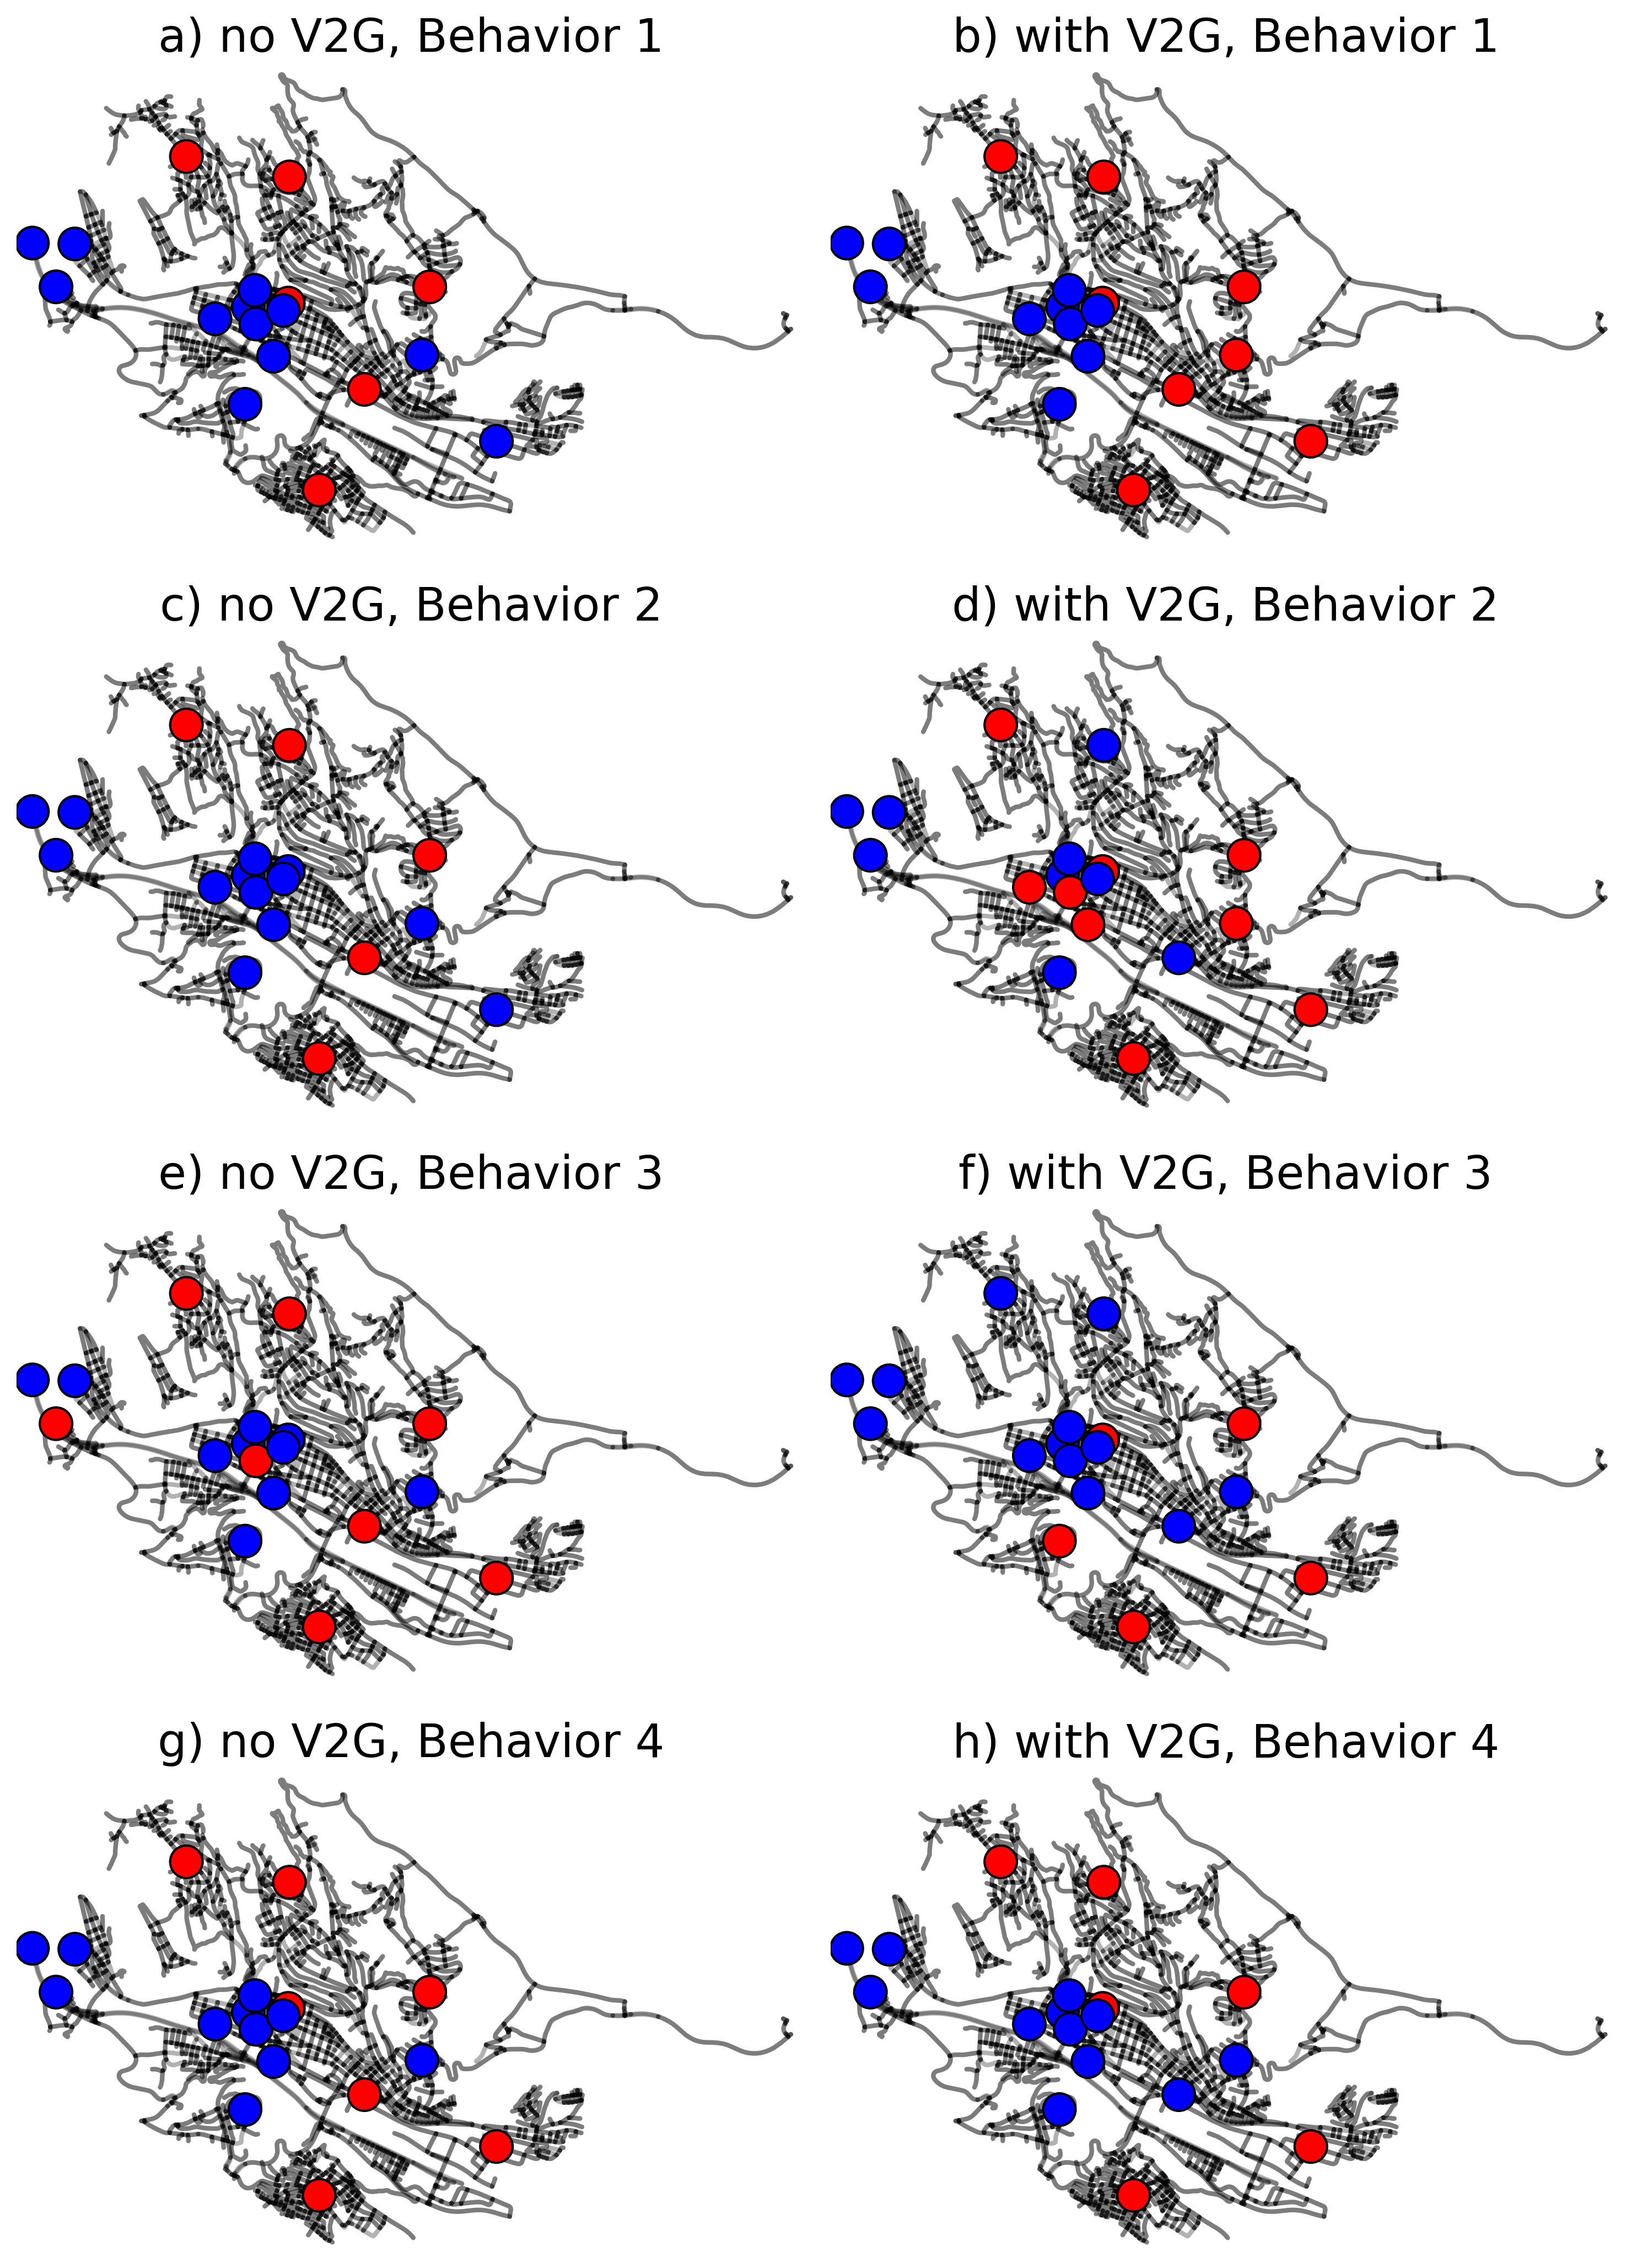

In [41]:
mpl.rcParams['figure.dpi'] = 300
fig,axs=plt.subplots(4,2,figsize=(10,14))
mpl.rcParams['text.usetex'] = False

time_intervals_list=[[0,96]]
cmap_name="bwr"
n_bins=5

evcs_occupation_dict_single_time={}


ax_order=[0,2,4,6,1,3,5,7]
figure_letter=['a','b','c','d','e','f','g','h']
ax_idx=0
axs_flatten=axs.flatten()
for v2g_name in p_v2g_dict.keys():
    for behavior in behavior_list:
        filtered_spatial_temporal_df=spatial_temporal_df[(spatial_temporal_df.v2g_behavior==v2g_name) & (spatial_temporal_df.user_behavior==behavior)]
        list_unique_evcs=list(set(filtered_spatial_temporal_df.evcs_node))


        for node in original_city.G.nodes:
            if(node in original_city.evcs_nodes):
                mean_value=10000*np.mean(filtered_spatial_temporal_df[filtered_spatial_temporal_df.evcs_node==node].evcs_occupation)
                if(np.isnan(mean_value)):
                    evcs_occupation_dict_single_time[node]=0
                else:
                    evcs_occupation_dict_single_time[node]=mean_value
            else:
                evcs_occupation_dict_single_time[node]=0
                
        normalized_node_size_list=[200 if node in original_city.evcs_nodes else 0 for node in original_city.G.nodes]

        G=copy.deepcopy(original_city.G)

        nx.set_node_attributes(G, evcs_occupation_dict_single_time, "charging_count")
        nc = ox.plot.get_node_colors_by_attr(G, "charging_count", cmap=cmap_name,num_bins=n_bins)
        ox.plot_graph(
            G,
            ax=axs_flatten[ax_order[ax_idx]],
            node_color=nc,
            node_edgecolor='k',
            node_size=normalized_node_size_list,
            node_zorder=2,
            bgcolor='w',
            edge_linewidth=2,
            edge_color="k",
            edge_alpha=0.3,
            show=False
        )
        fig.facecolor='white'

        attribute=list(evcs_occupation_dict_single_time.values())
        norm=plt.Normalize(vmin=min(attribute), vmax=max(attribute))
        #norm=plt.Normalize(vmin=0,vmax=30)
        #cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap("YlOrRd",5)), ax=ax, orientation='vertical',shrink=0.5)
        #cb.set_label('EVCS daily mean occupation level (%)', fontsize = 10)
        if(v2g_name=='no_v2g'):
            v2g_str='no V2G'
        else:
            v2g_str='with V2G'
        axs_flatten[ax_order[ax_idx]].set_title('{}) {}, Behavior {}'.format(figure_letter[ax_order[ax_idx]],v2g_str,behavior[-1]),size=20)
        folder_to_save=r'C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_applied_energy\main_results\evcs_occupation_level'
        file_name='spatial_analysis_ostfildern_v2g_behavior_{}_user_behavior={}.png'.format(v2g_name,behavior)
        #plt.savefig(os.path.join(folder_to_save,file_name),dpi=300)
        #plt.show()
        ax_idx+=1
#cax = fig.add_axes([ax.get_position().x1+0.22,ax.get_position().y0,0.02,ax.get_position().height])
#cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap(cmap_name,n_bins)), orientation='vertical',cax=cax)
#sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap_name,n_bins))
#plt.colorbar(sm,label='Traffic level',orientation='horizontal',fraction=0.15)
#cb.ax.tick_params(labelsize=15) 
#cb.set_label('Posterior Causal Effect', fontsize = 20)
plt.tight_layout()
plt.show()

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  bin_colors = get_colors(num_bins, cmap, start, stop)
C:\Users\hoc\AppData\Local\Temp\ipykernel_14492\548844824.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap("YlOrRd",5)), ax=ax, orientation='vertical',shrink=0.5)


<Figure size 1920x1440 with 0 Axes>

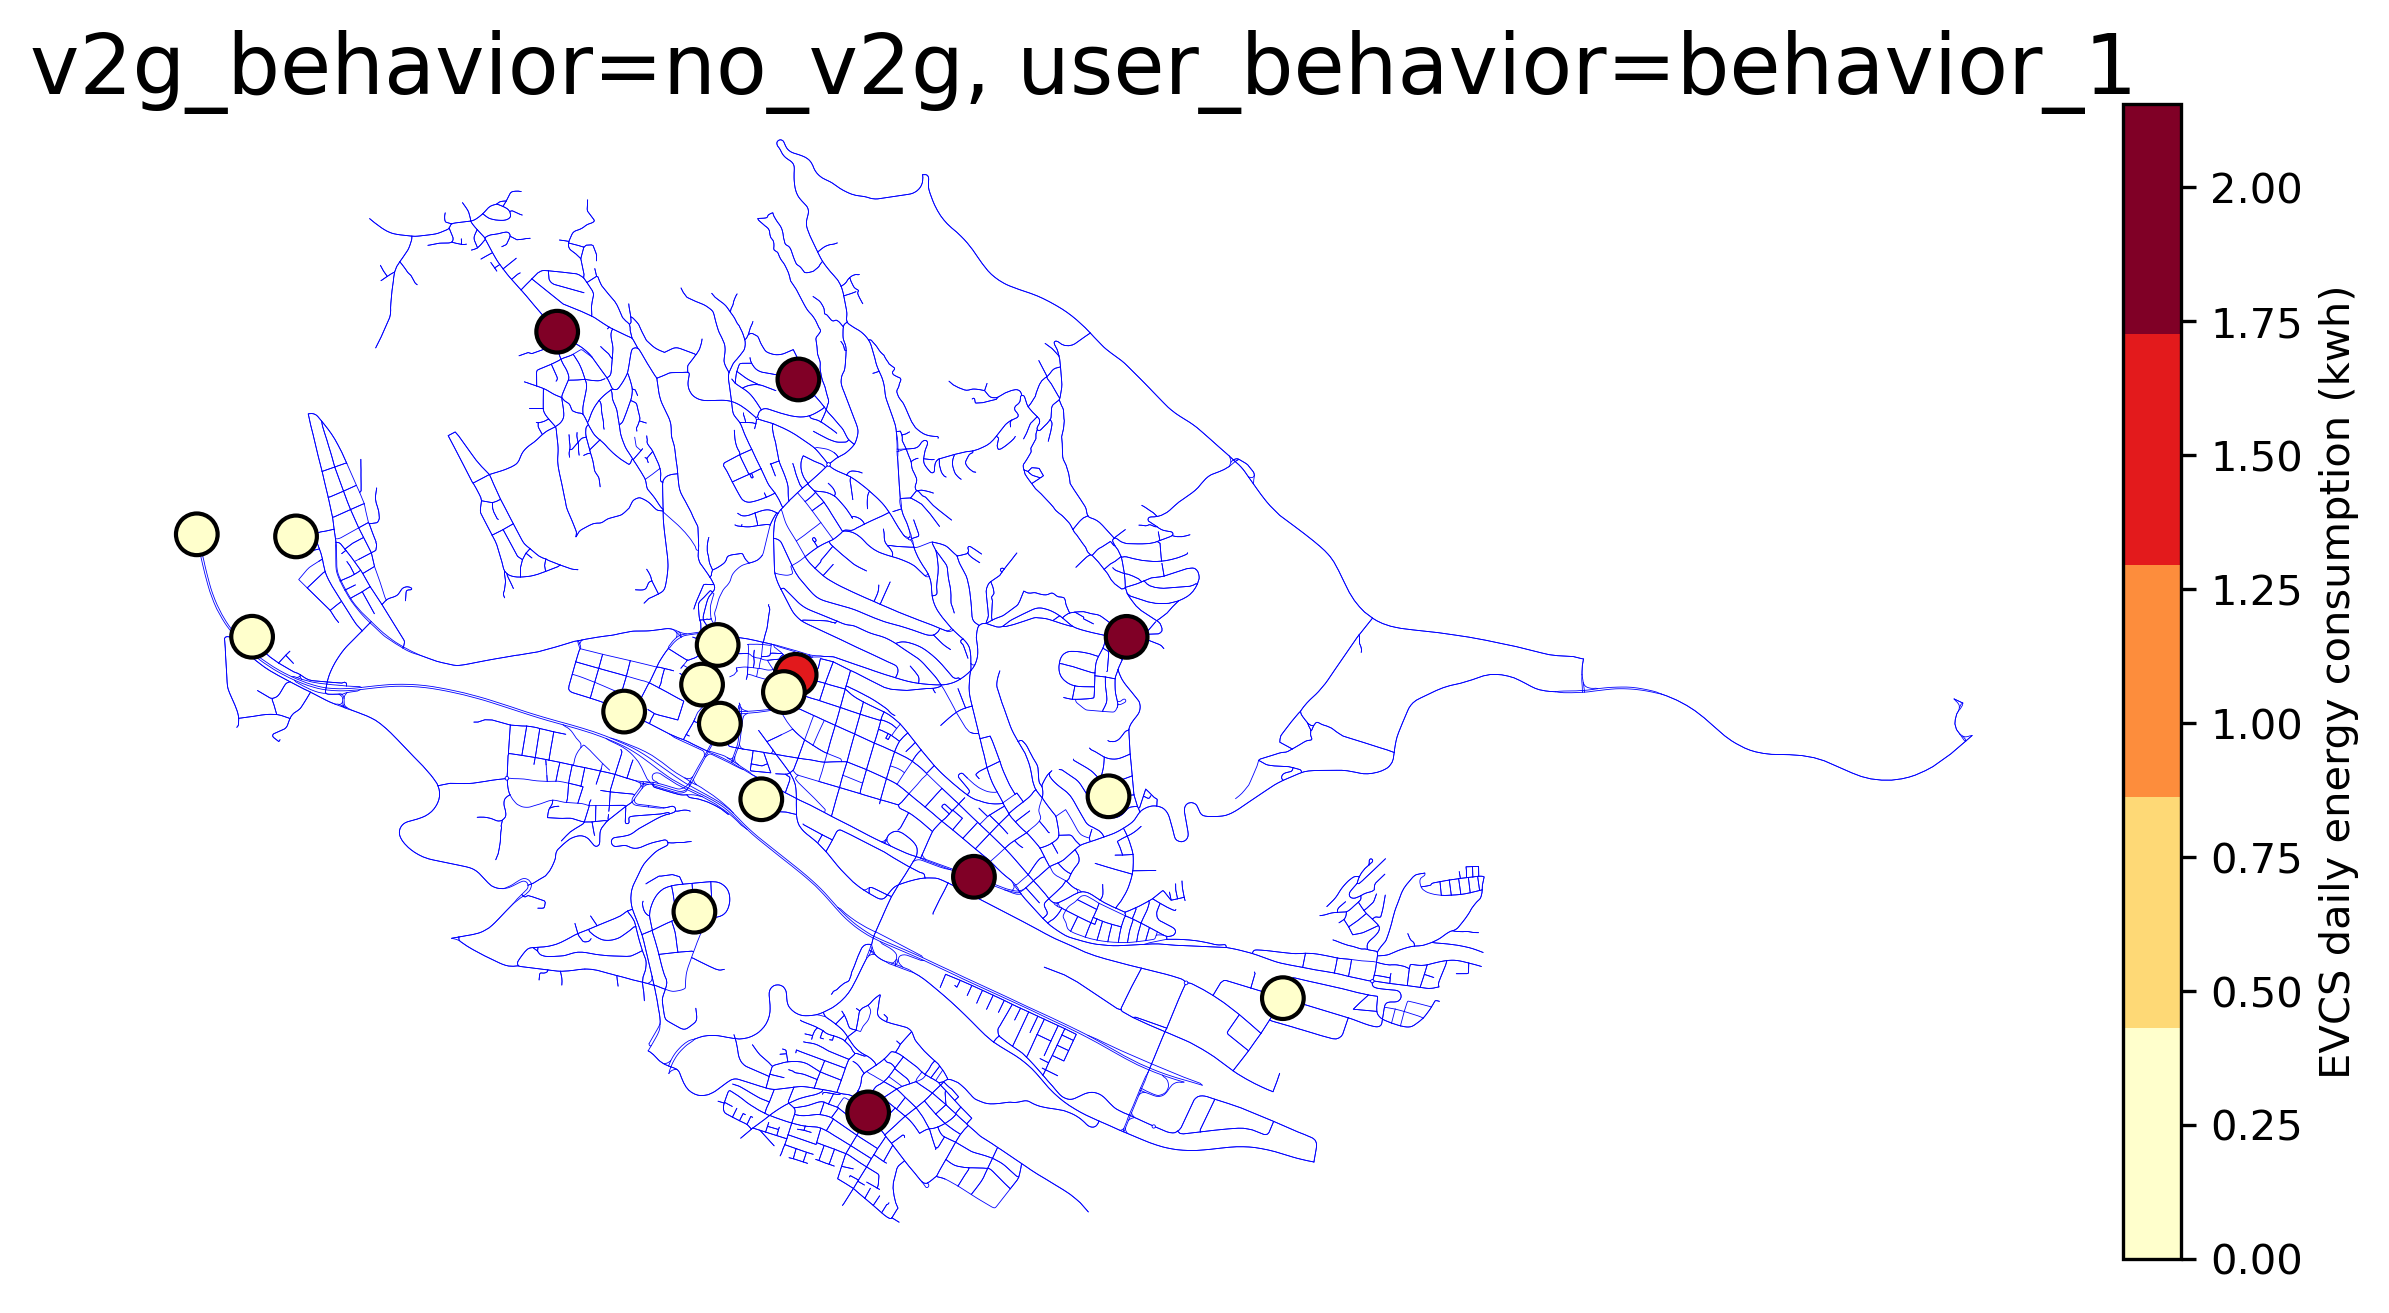

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  bin_colors = get_colors(num_bins, cmap, start, stop)
C:\Users\hoc\AppData\Local\Temp\ipykernel_14492\548844824.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap("YlOrRd",5)), ax=ax, orientation='vertical',shrink=0.5)


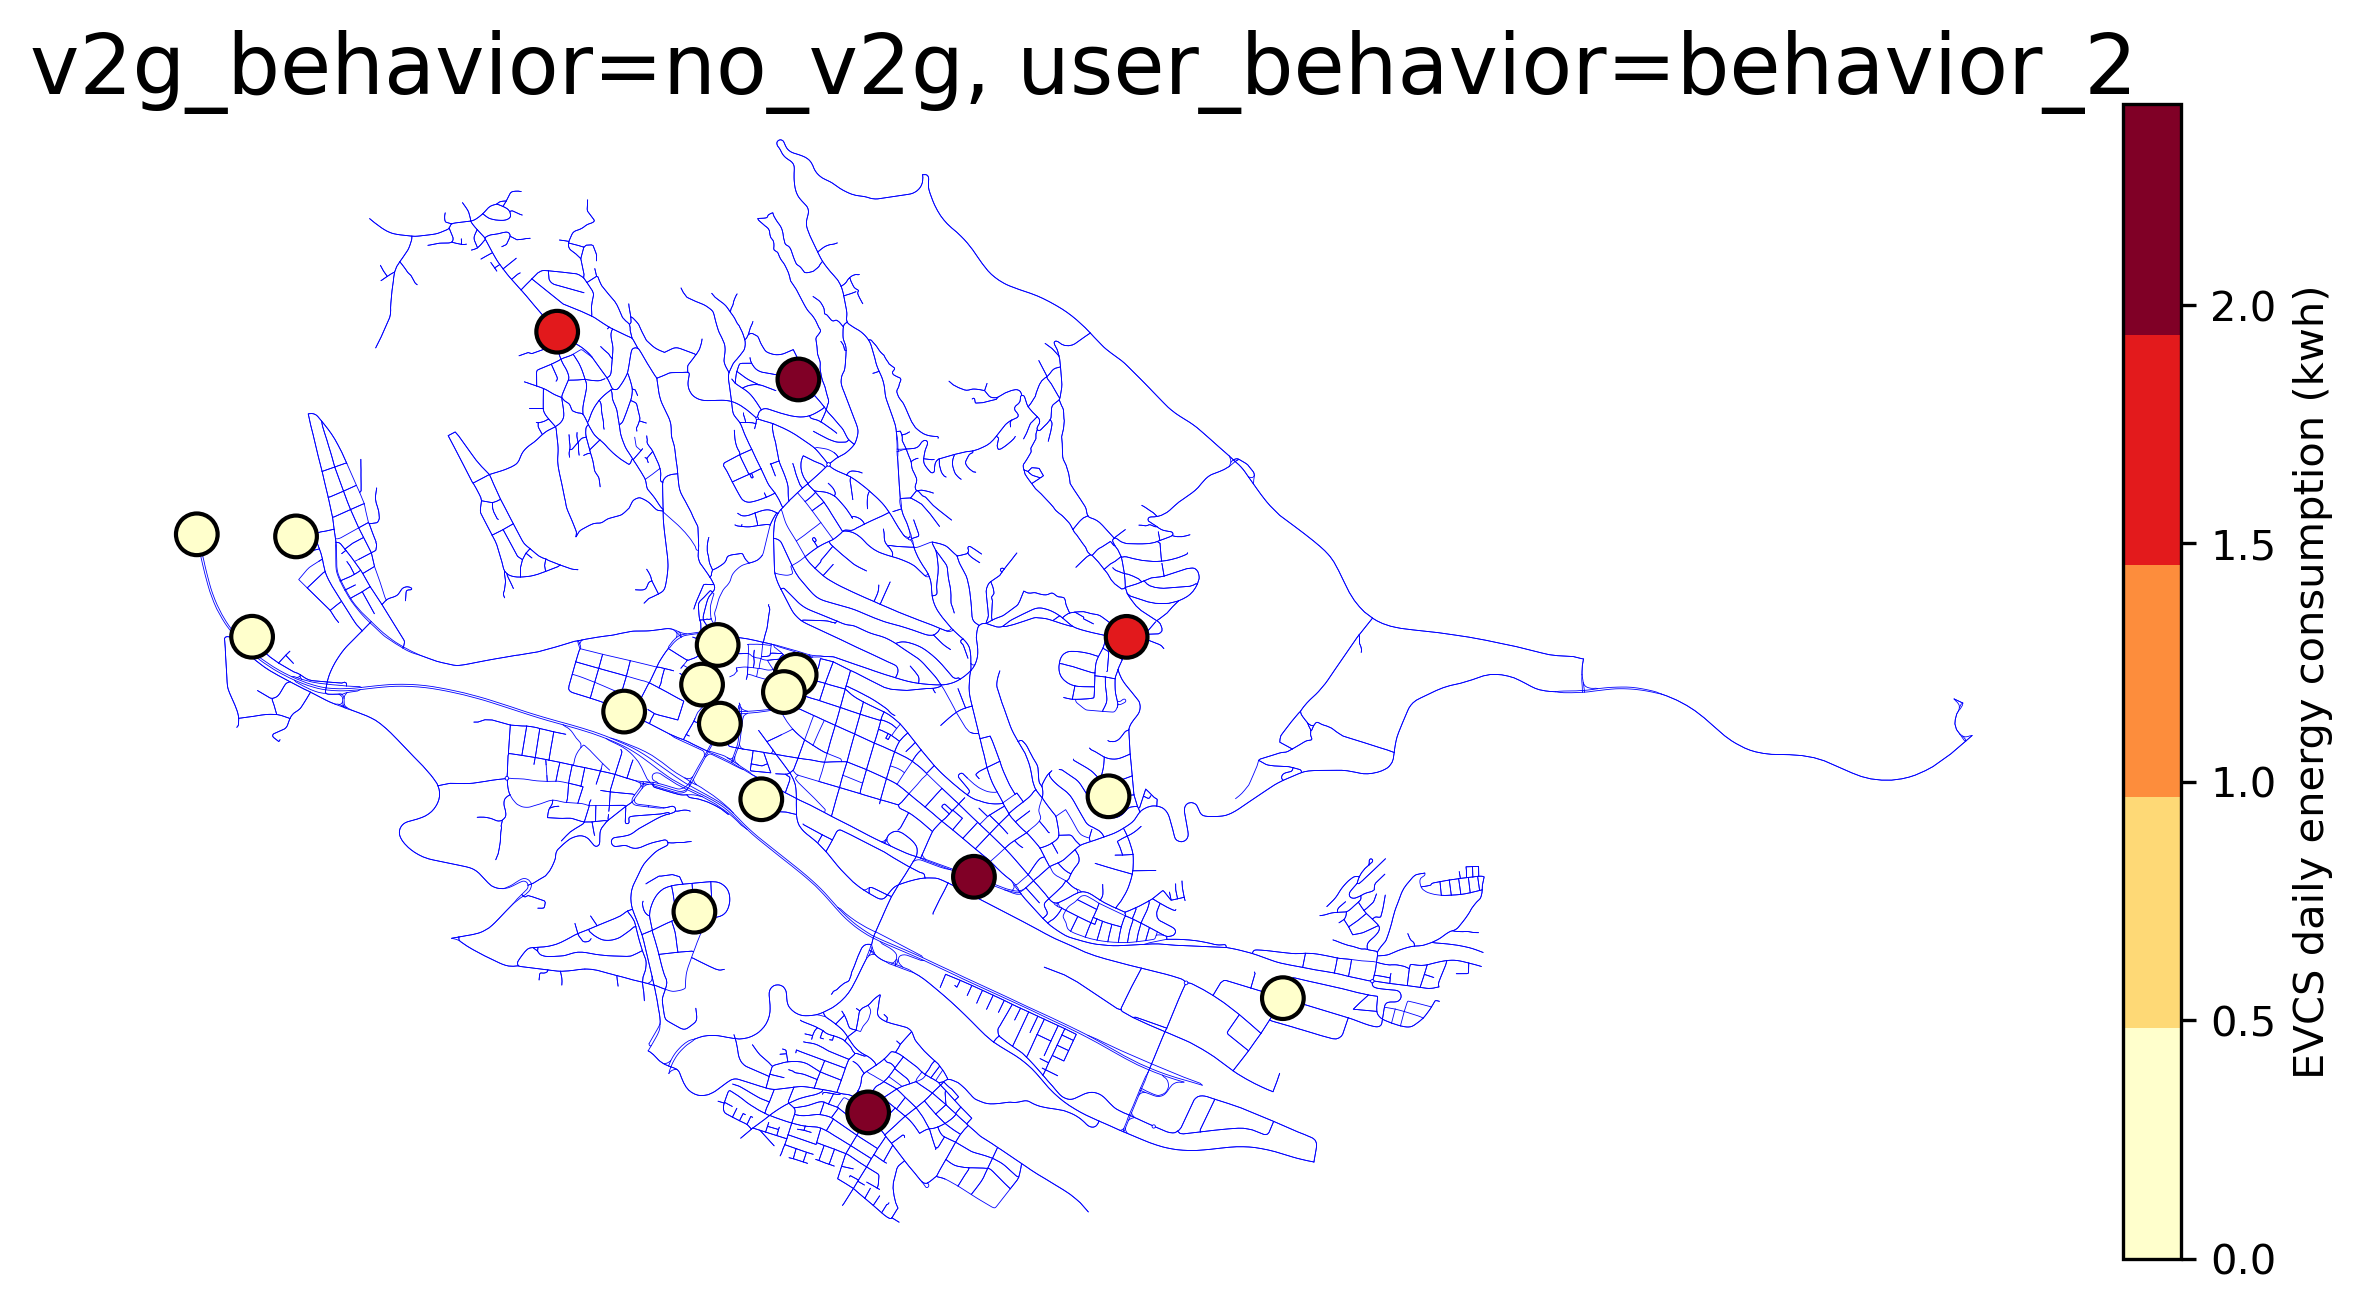

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  bin_colors = get_colors(num_bins, cmap, start, stop)
C:\Users\hoc\AppData\Local\Temp\ipykernel_14492\548844824.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap("YlOrRd",5)), ax=ax, orientation='vertical',shrink=0.5)


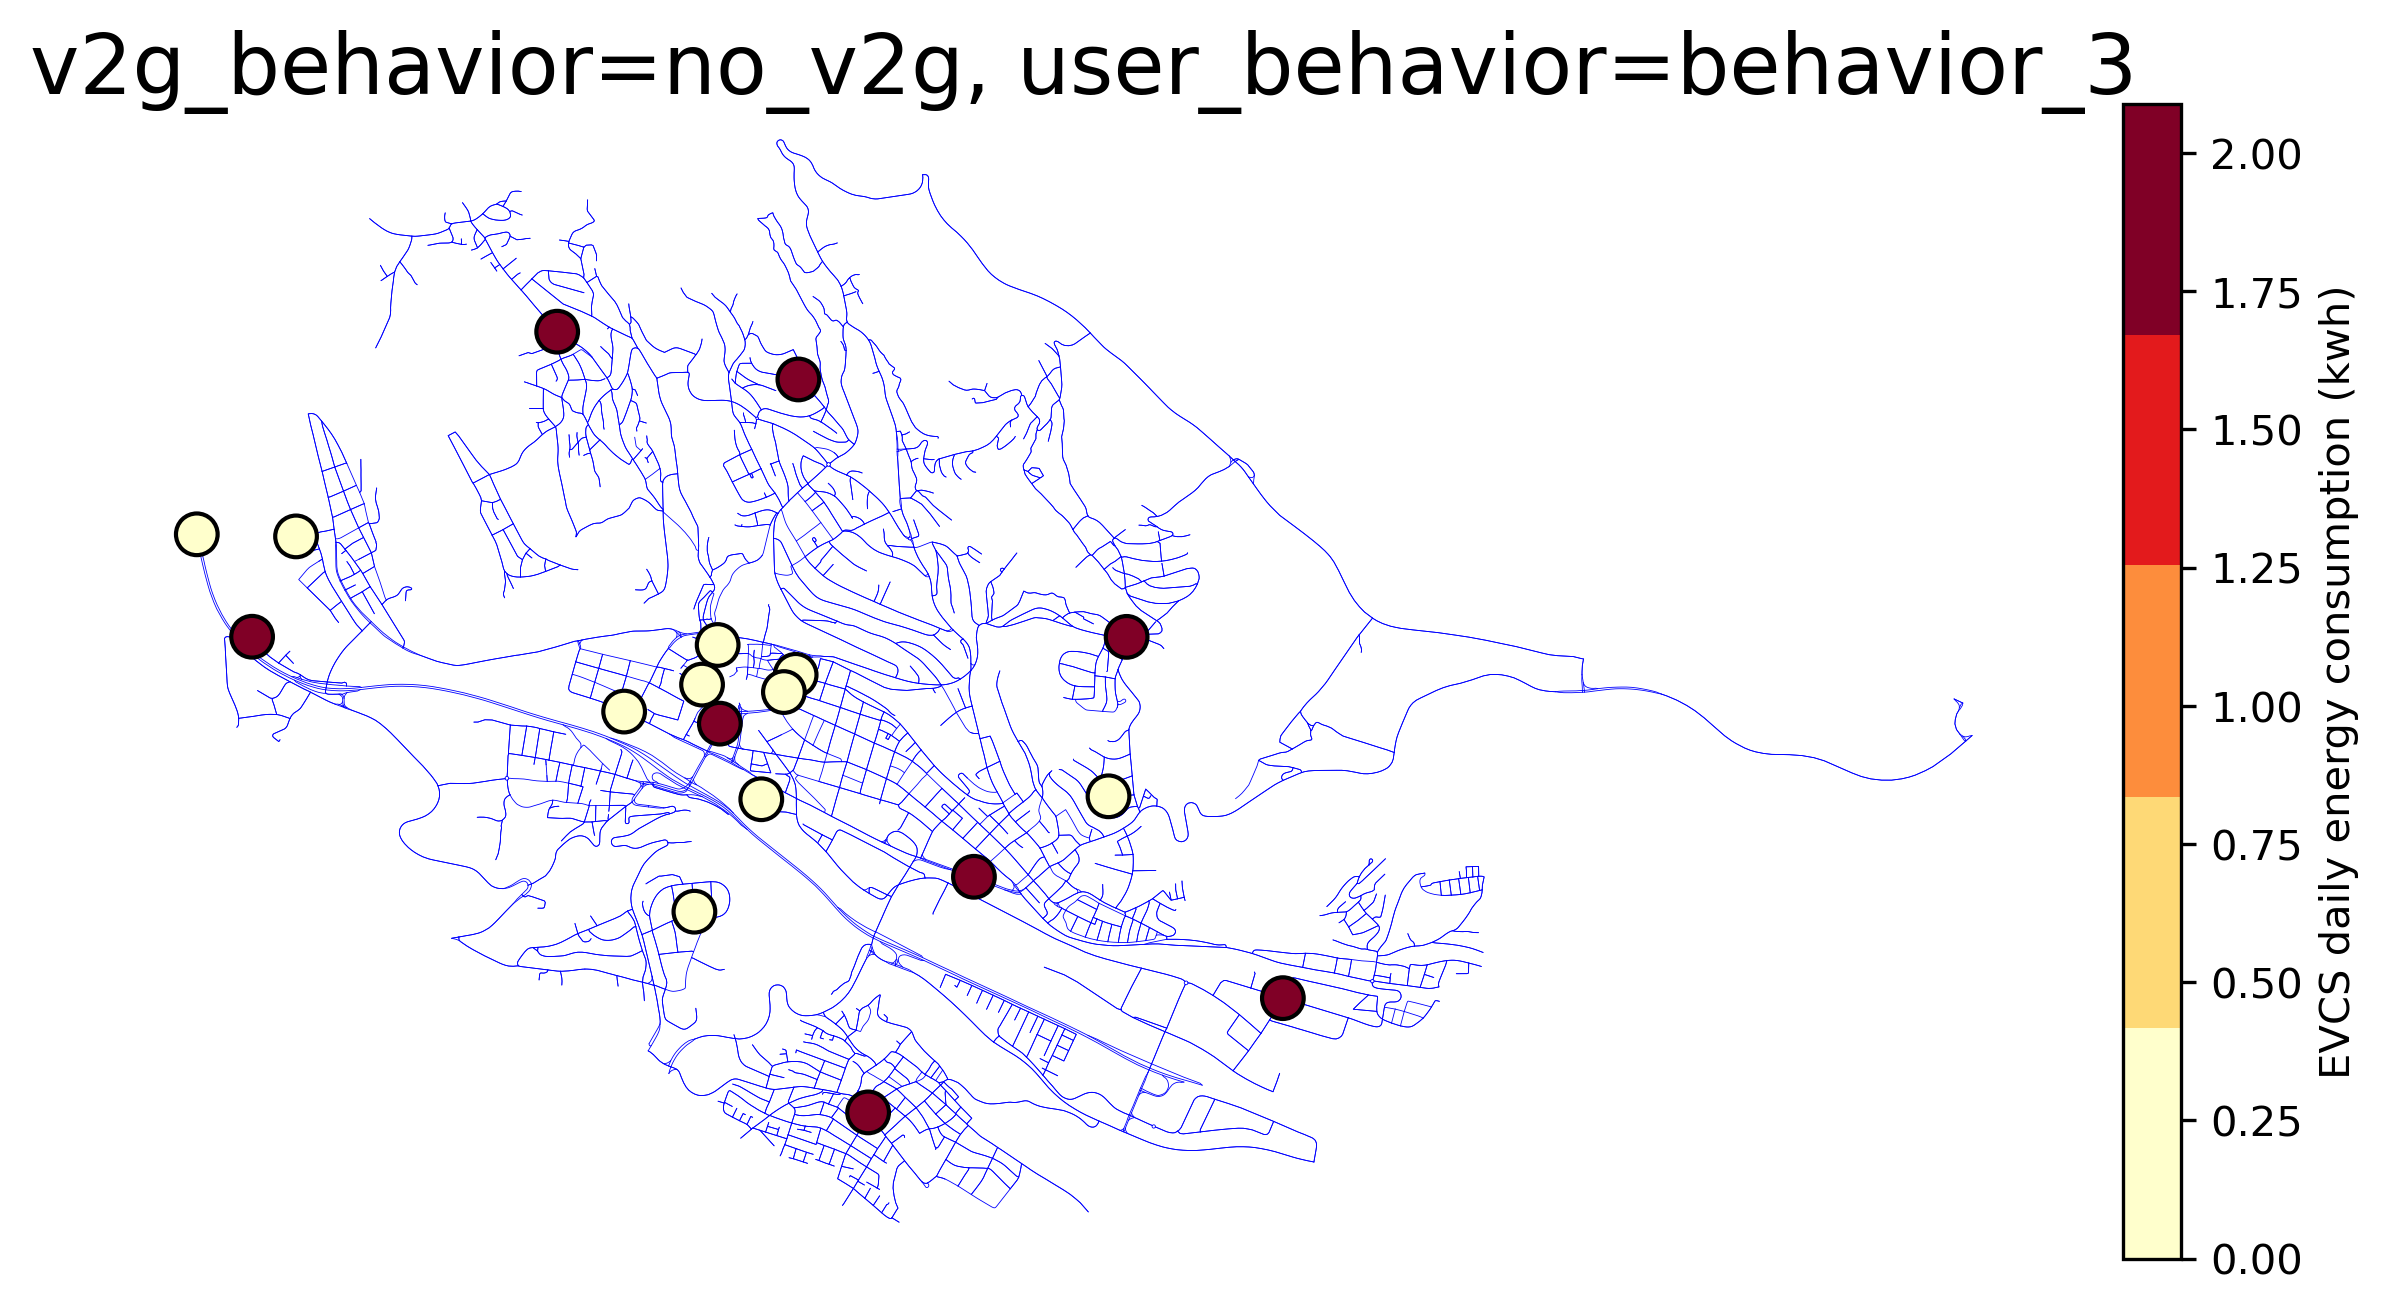

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  bin_colors = get_colors(num_bins, cmap, start, stop)
C:\Users\hoc\AppData\Local\Temp\ipykernel_14492\548844824.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap("YlOrRd",5)), ax=ax, orientation='vertical',shrink=0.5)


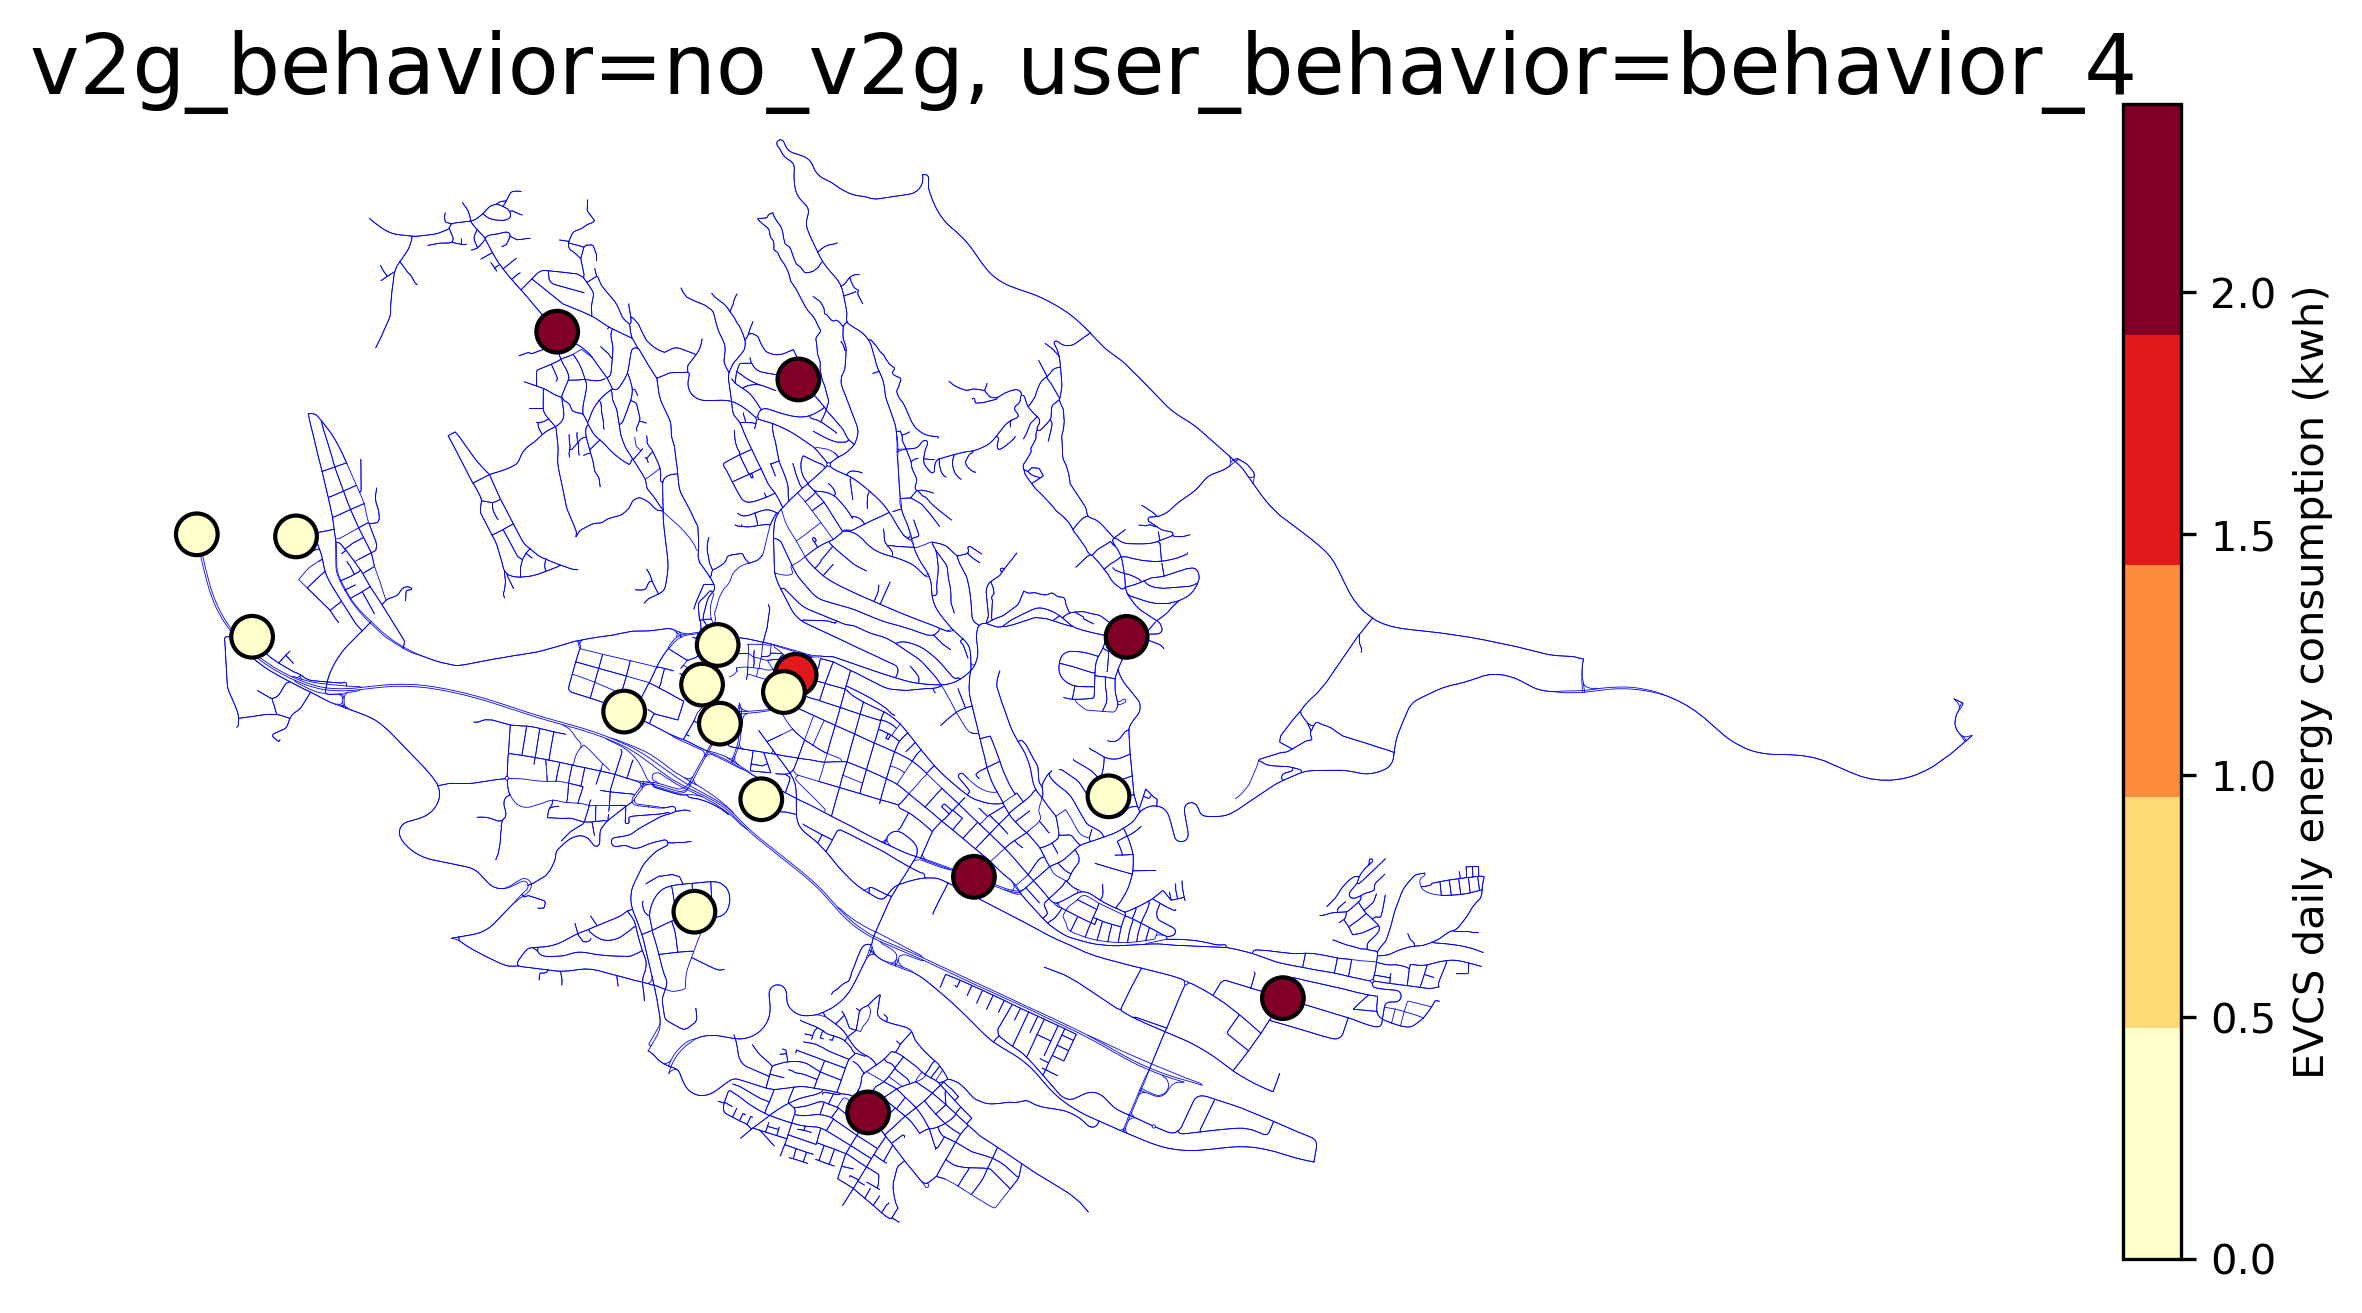

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  bin_colors = get_colors(num_bins, cmap, start, stop)
C:\Users\hoc\AppData\Local\Temp\ipykernel_14492\548844824.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap("YlOrRd",5)), ax=ax, orientation='vertical',shrink=0.5)


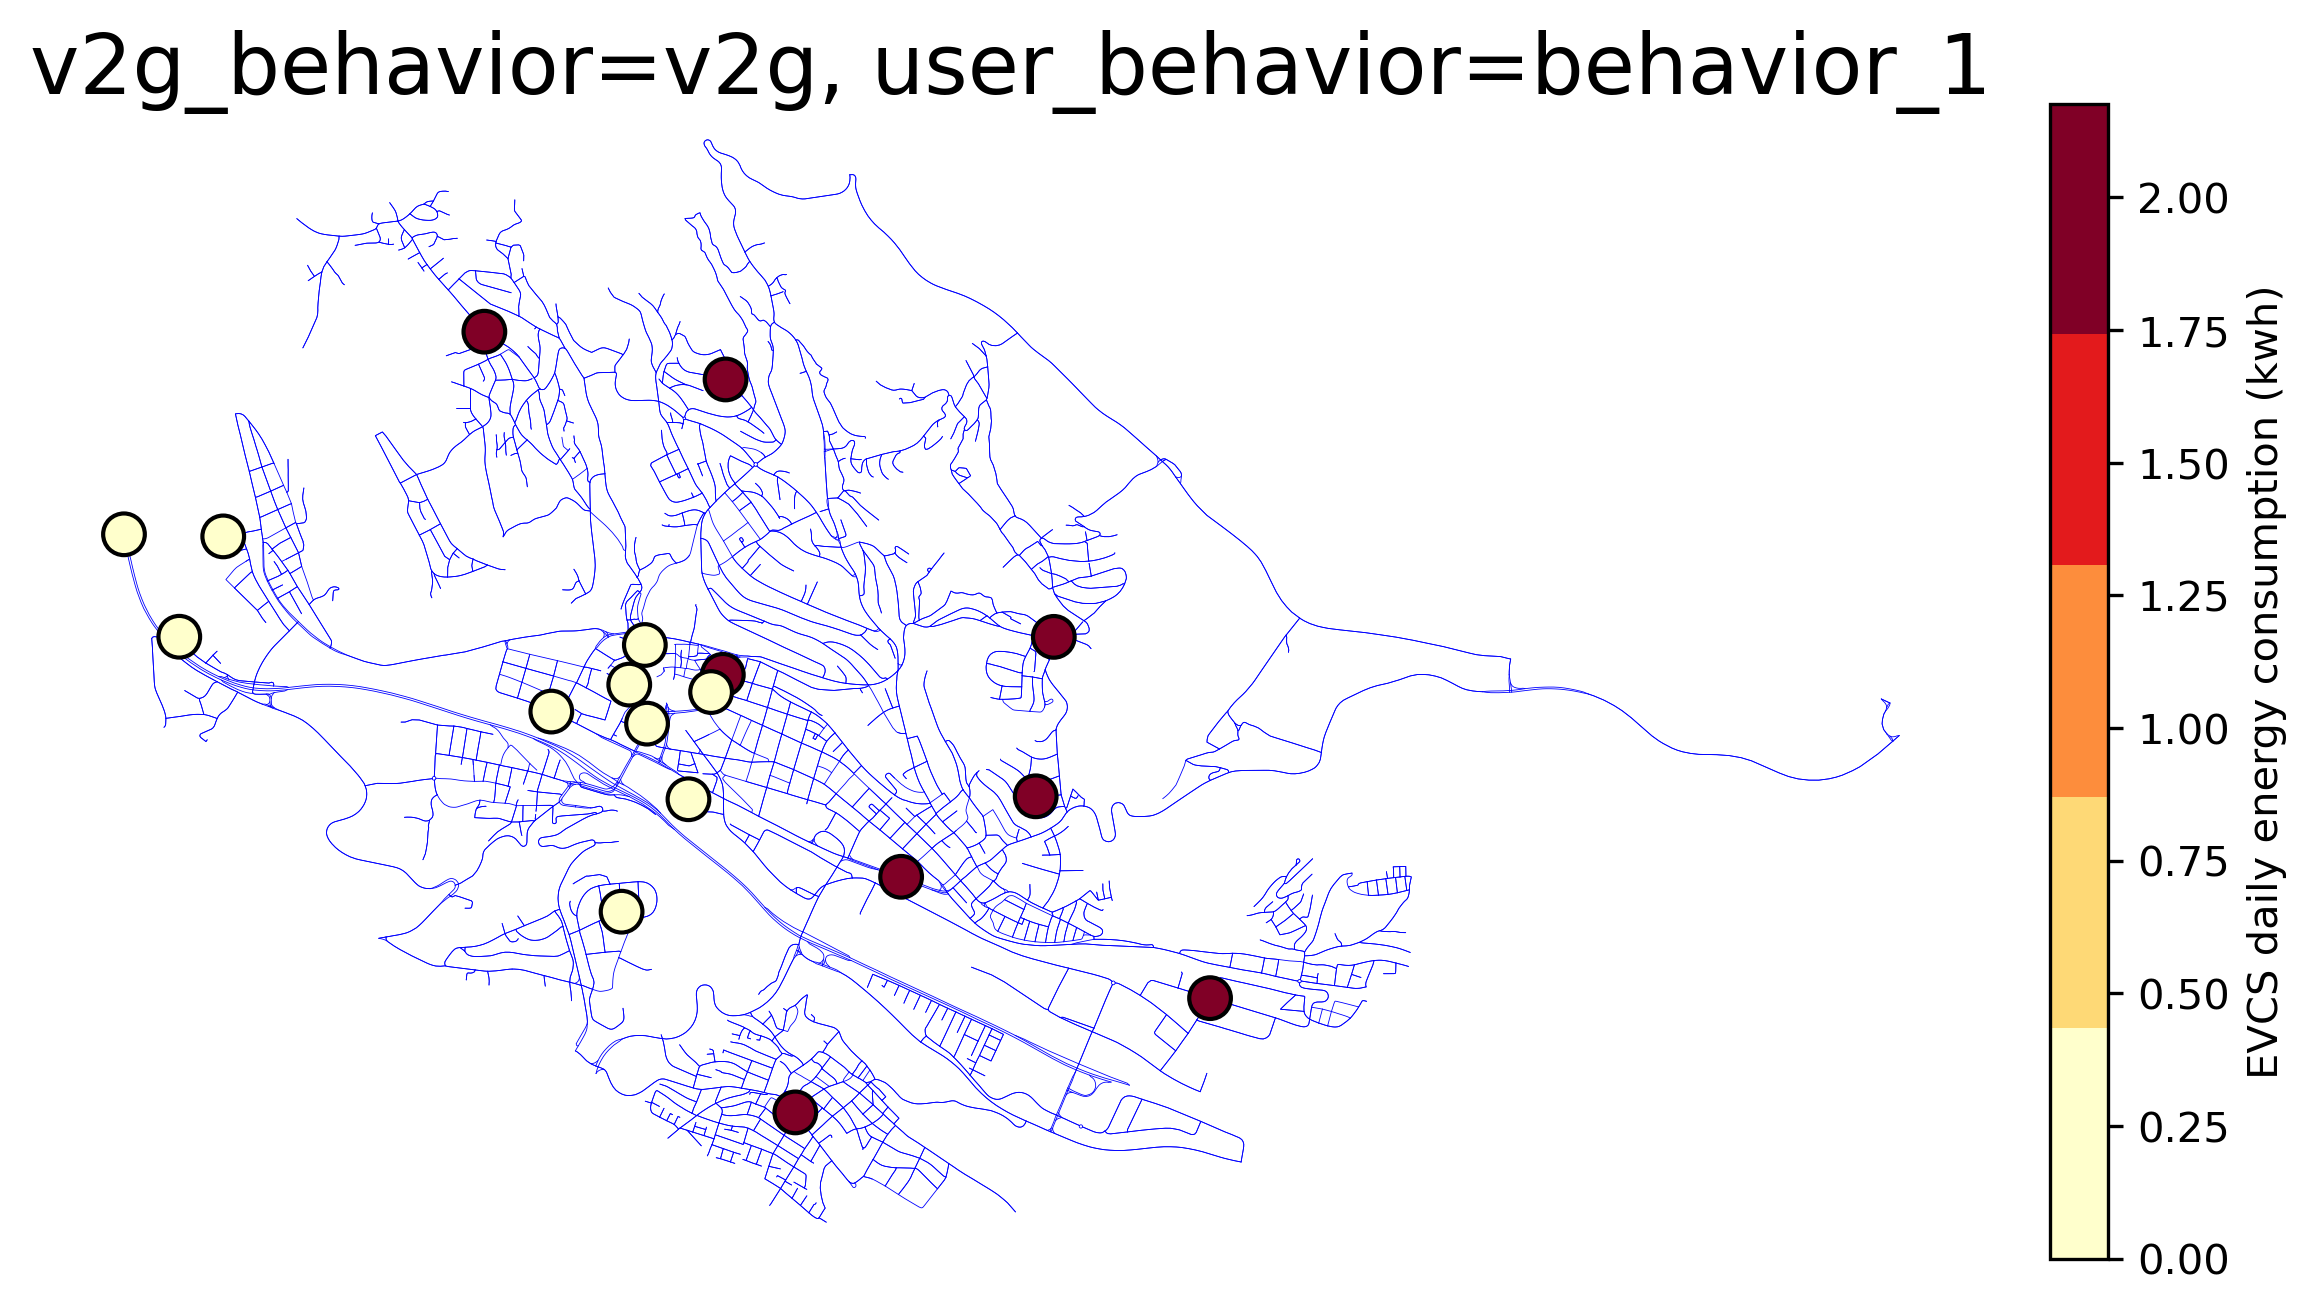

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  bin_colors = get_colors(num_bins, cmap, start, stop)
C:\Users\hoc\AppData\Local\Temp\ipykernel_14492\548844824.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap("YlOrRd",5)), ax=ax, orientation='vertical',shrink=0.5)


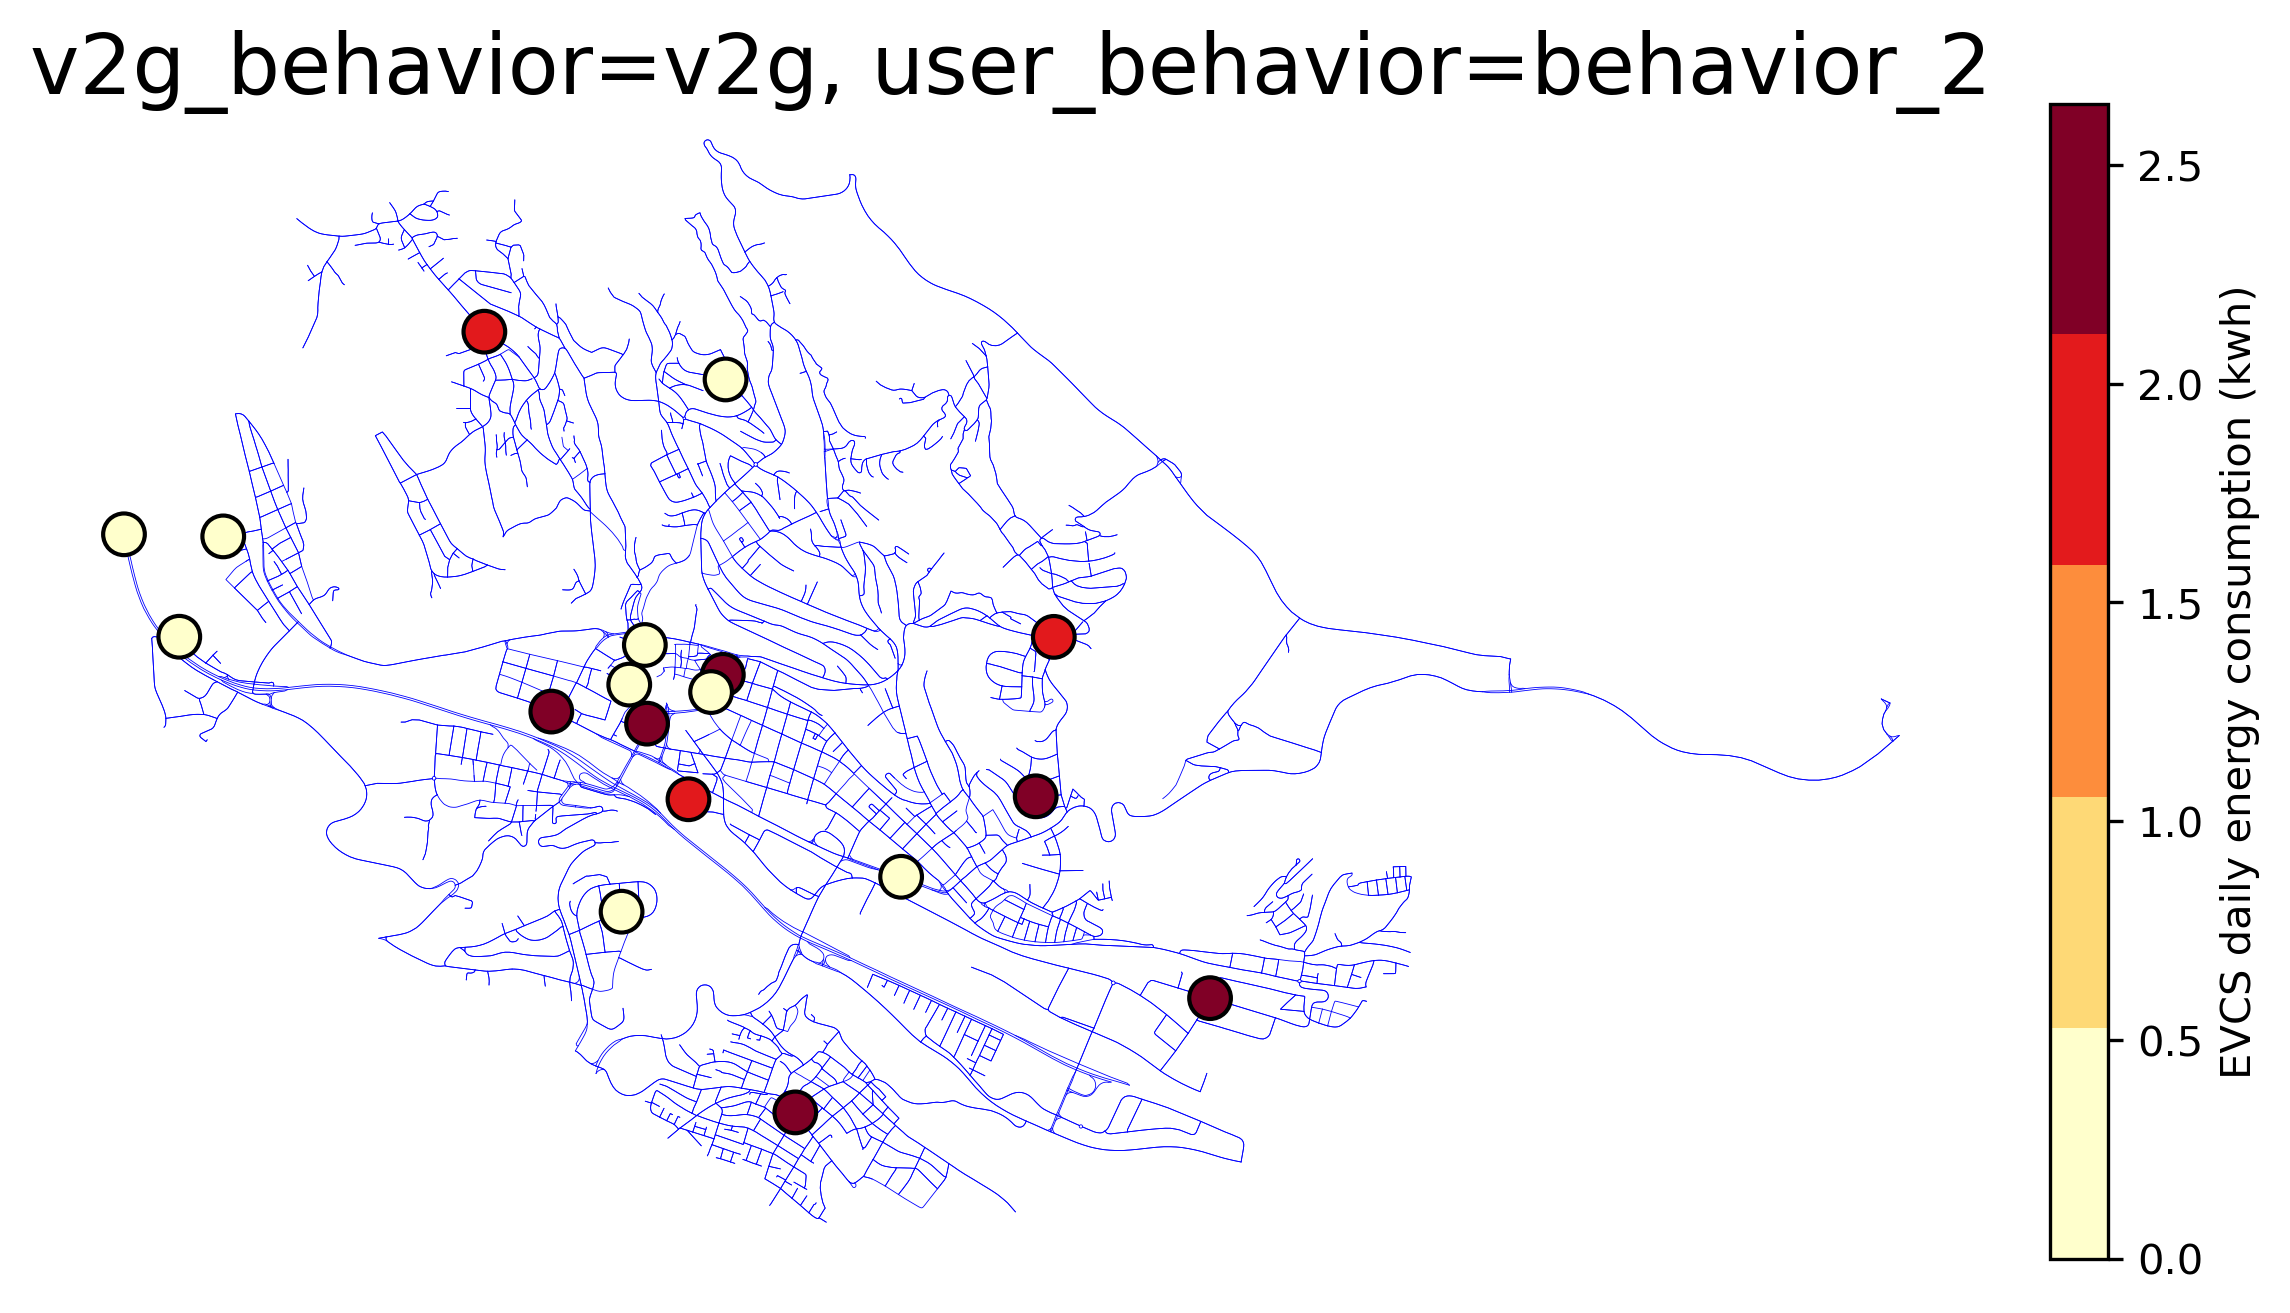

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  bin_colors = get_colors(num_bins, cmap, start, stop)
C:\Users\hoc\AppData\Local\Temp\ipykernel_14492\548844824.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap("YlOrRd",5)), ax=ax, orientation='vertical',shrink=0.5)


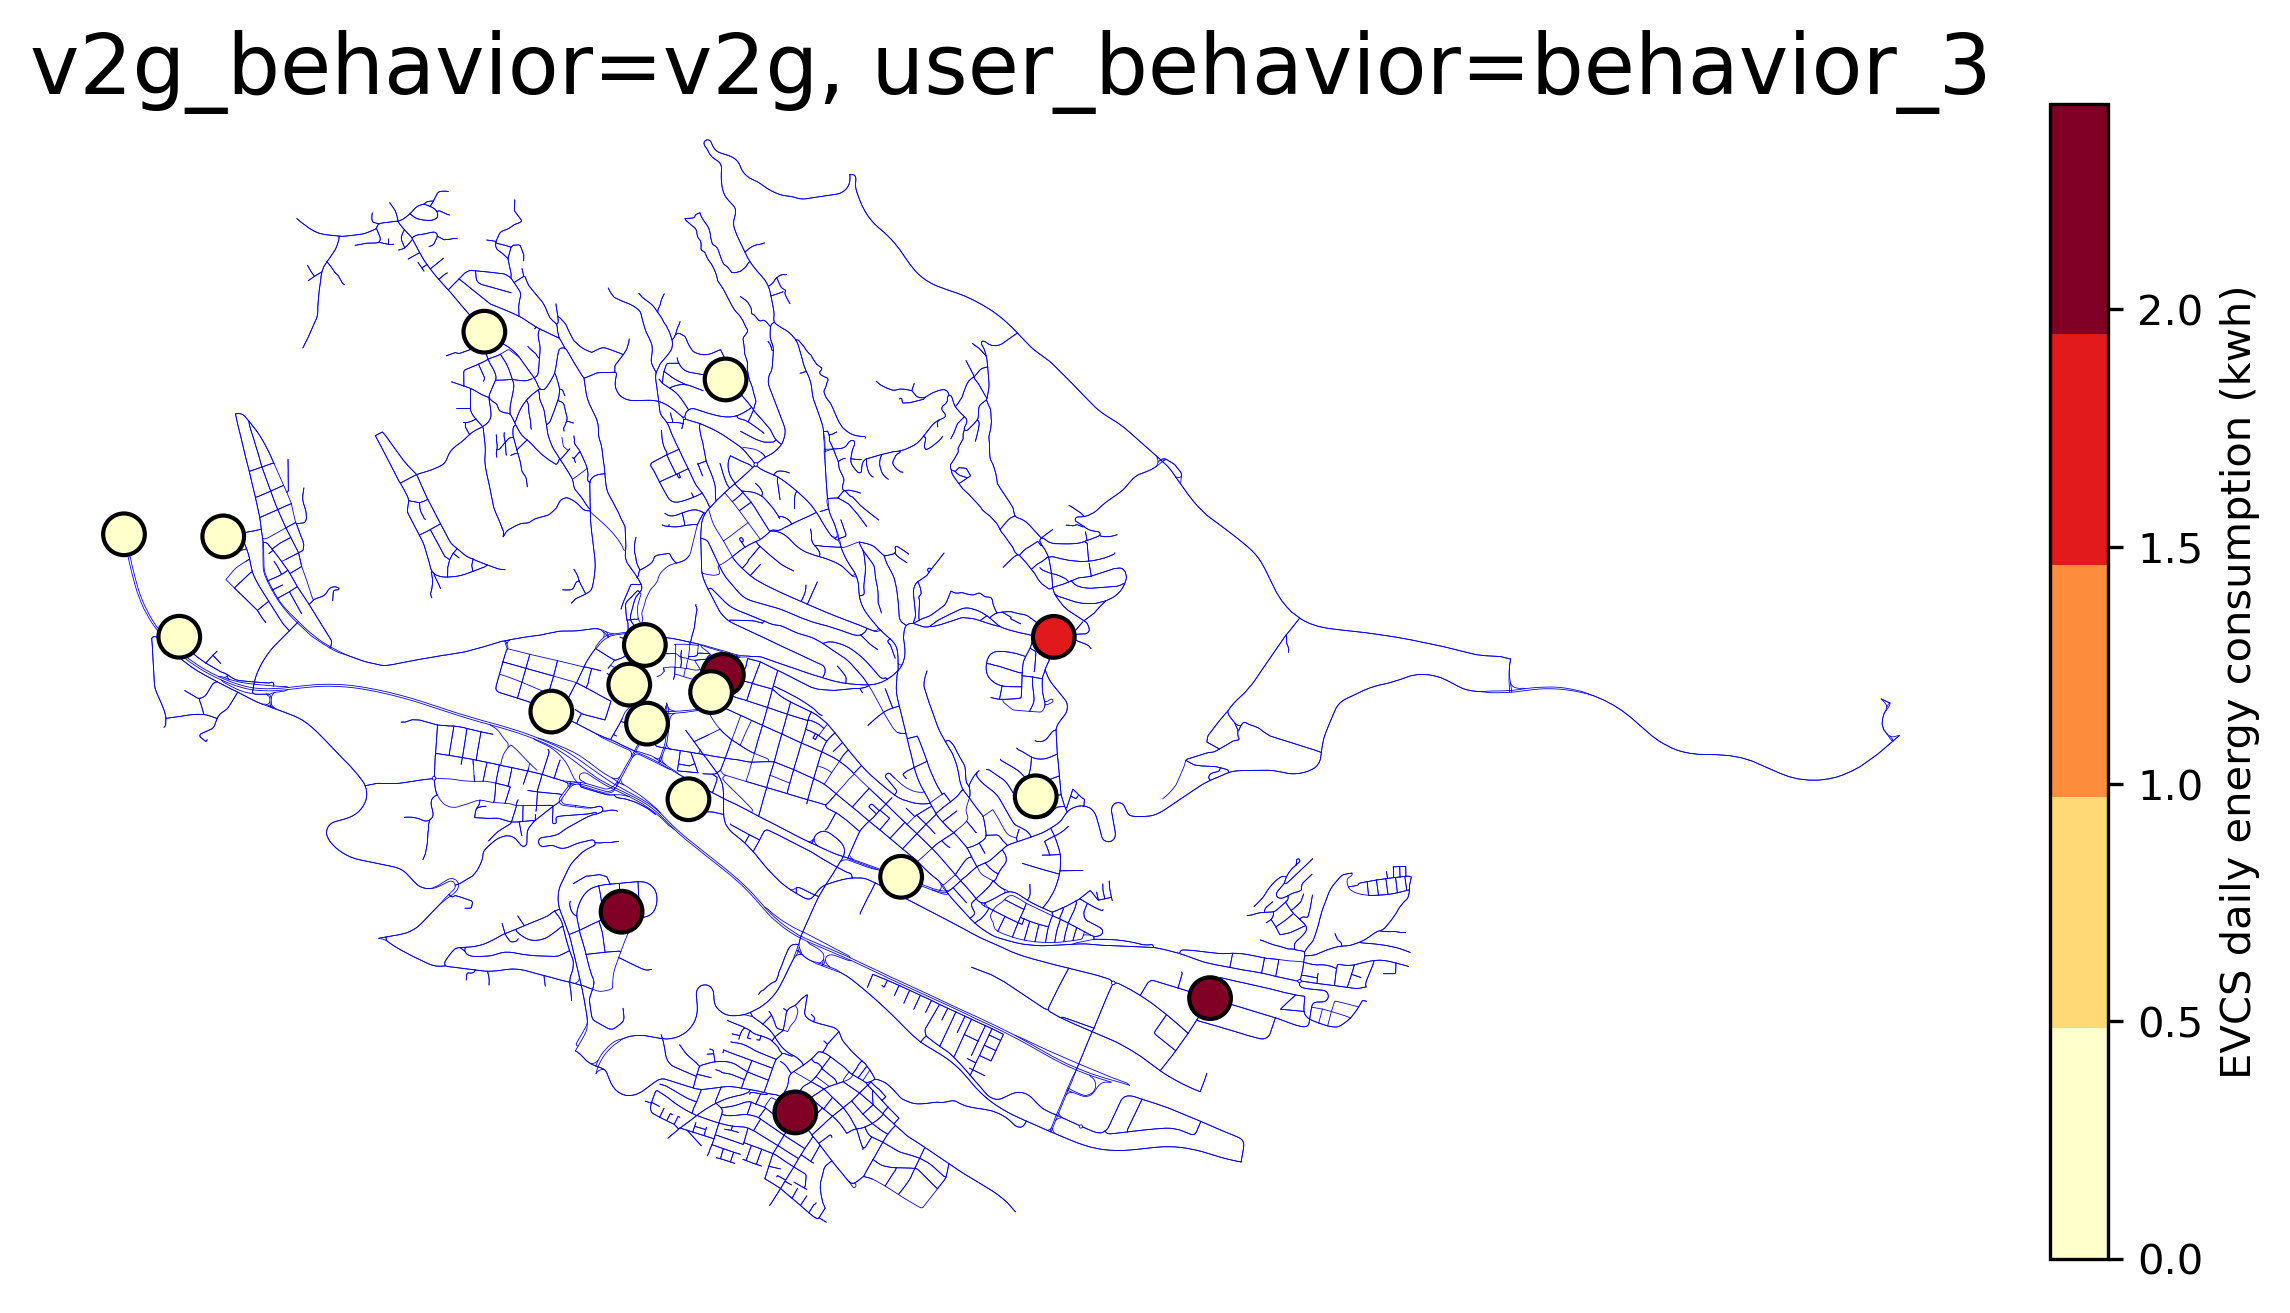

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\osmnx\plot.py:883: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  bin_colors = get_colors(num_bins, cmap, start, stop)
C:\Users\hoc\AppData\Local\Temp\ipykernel_14492\548844824.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap("YlOrRd",5)), ax=ax, orientation='vertical',shrink=0.5)


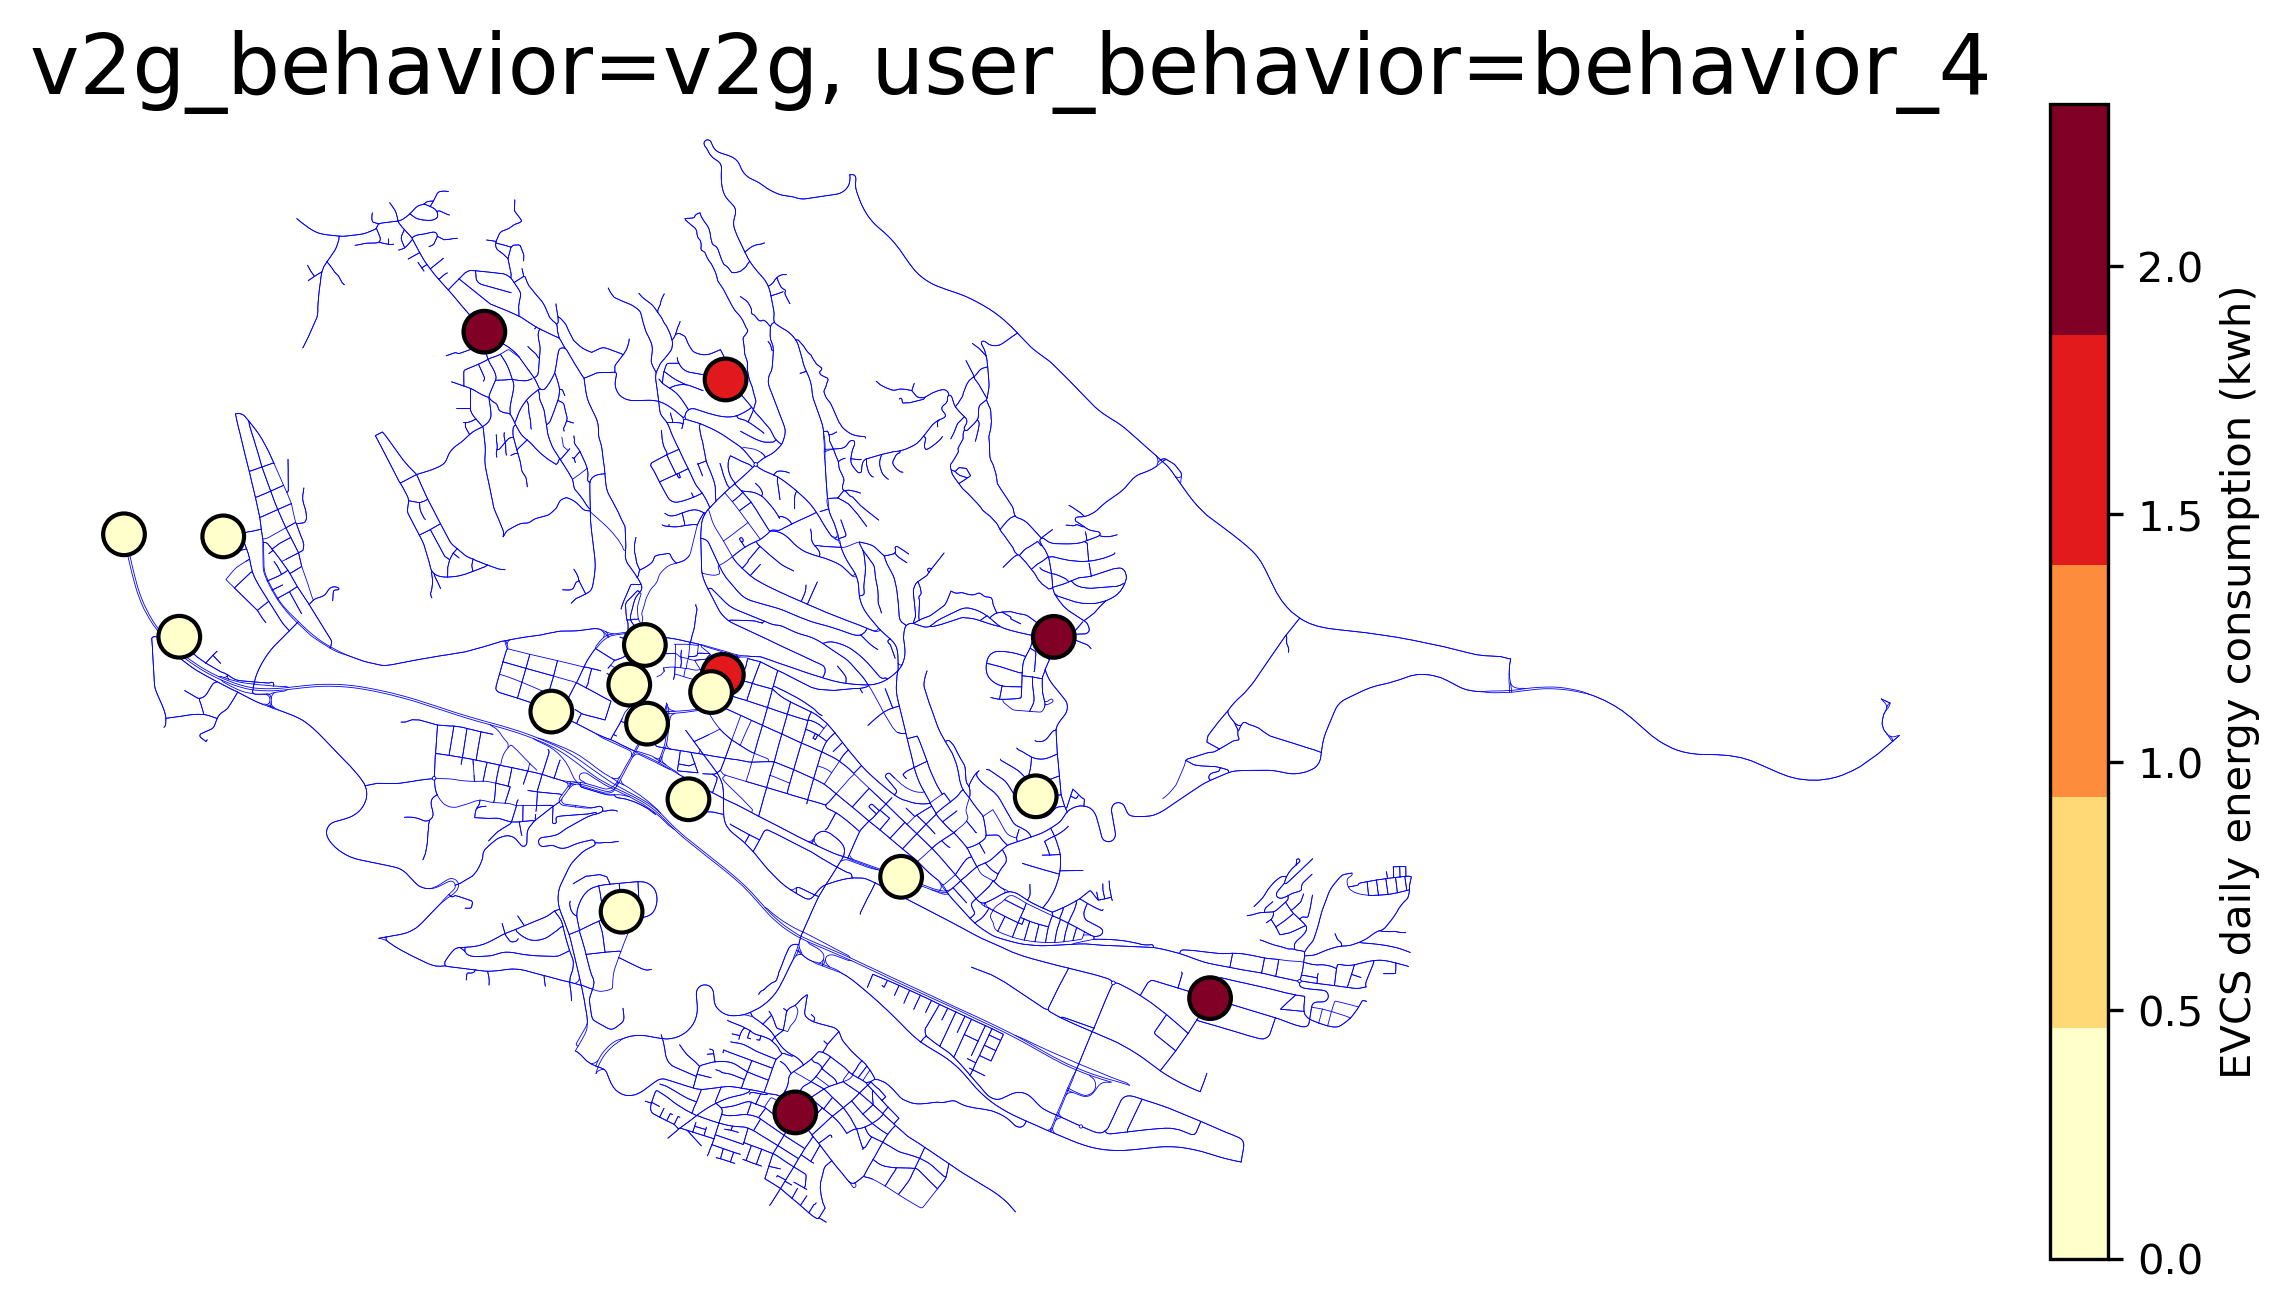

In [20]:
mpl.rcParams['figure.dpi'] = 300
fig = plt.figure(facecolor='white')

time_intervals_list=[[0,96]]


evcs_occupation_dict_single_time={}

for v2g_name in p_v2g_dict.keys():
    for behavior in behavior_list:
        filtered_spatial_temporal_df=spatial_temporal_df[(spatial_temporal_df.v2g_behavior==v2g_name) & (spatial_temporal_df.user_behavior==behavior)]
        list_unique_evcs=list(set(filtered_spatial_temporal_df.evcs_node))


        for node in original_city.G.nodes:
            if(node in original_city.evcs_nodes):
                mean_value=np.mean(filtered_spatial_temporal_df[filtered_spatial_temporal_df.evcs_node==node].charging_balance)
                if(np.isnan(mean_value)):
                    evcs_occupation_dict_single_time[node]=0
                else:
                    evcs_occupation_dict_single_time[node]=mean_value
            else:
                evcs_occupation_dict_single_time[node]=0
                
        normalized_node_size_list=[100 if node in original_city.evcs_nodes else 0 for node in original_city.G.nodes]

        G=copy.deepcopy(original_city.G)

        nx.set_node_attributes(G, evcs_occupation_dict_single_time, "charging_count")
        nc = ox.plot.get_node_colors_by_attr(G, "charging_count", cmap="YlOrRd",num_bins=5)
        fig, ax = ox.plot_graph(
            G,
            node_color=nc,
            node_edgecolor='k',
            node_size=normalized_node_size_list,
            node_zorder=2,
            bgcolor='w',
            edge_linewidth=0.2,
            edge_color="b",
            show=False
        )
        fig.facecolor='white'

        attribute=list(evcs_occupation_dict_single_time.values())
        norm=plt.Normalize(vmin=min(attribute), vmax=max(attribute))
        #norm=plt.Normalize(vmin=0,vmax=30)
        cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap("YlOrRd",5)), ax=ax, orientation='vertical',shrink=0.5)
        cb.set_label('EVCS daily energy consumption (kwh)', fontsize = 10)
        plt.title('v2g_behavior={}, user_behavior={}'.format(v2g_name,behavior),size=20)
        plt.tight_layout()
        folder_to_save=r'C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_applied_energy\main_results\evcs_occupation_level'
        file_name='spatial_analysis_ostfildern_v2g_behavior_{}_user_behavior={}.png'.format(v2g_name,behavior)
        #plt.savefig(os.path.join(folder_to_save,file_name),dpi=300)
        plt.show()
